In [4]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9
import DiaSourceTools as DSTools

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

import numpy as np

from astropy.table import Table

import sncosmo

%matplotlib inline

In [82]:
#This method allows to find matches pair to pair. Input is the list of catalogs with their visit id.
def find_paired_matches(subtr_visits):

    paired_matches = []
    for i, (visit, diaSrcs) in enumerate(subtr_visits):

        if i+1 == len(subtr_visits):
            break

        next_visit, next_diaSrcs = subtr_visits[i+1]

        match = afwTable.matchRaDec(diaSrcs, next_diaSrcs, afwGeom.Angle(1./3600., afwGeom.degrees)) 
        for m in match:
            paired_matches.append((visit, next_visit, m))
    return paired_matches

def source_distance(src1, src2):
    ra, dec = src1['coord_ra'], src1['coord_dec']
    ra2, dec2 = src2['coord_ra'], src2['coord_dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600

def add_pair_to_list(light_curves, pair):
    
    #print pair
    for lc in light_curves:
        v, s = pair[0]
        if lc[-1][-1].getId() == pair[0][-1].getId():
            
            lc.append(pair[-1])
            return True
        elif source_distance(lc[-1][-1], pair[0][-1]) < 1:
            lc.append(pair[0])
            lc.append(pair[-1])
            return True
    light_curves.append(pair)
    return False

def add_pair_to_list2(light_curves, pair):
    
    #print pair
    for lc in light_curves:
        v, s = pair[0]
        if lc[-1][-1].getId() == pair[0][-1].getId():
            
            lc.append(pair[-1])
            return True
    light_curves.append(pair)
    return False

def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves

#The input is a list of tuples for all matches between catalogs.
def create_light_curves(paired_matches):

    light_curves = []
    c_paired_matches = list(paired_matches)

    while len(c_paired_matches)>0:
        visit, n_visit, match = c_paired_matches.pop(0)
        points = []
        points.append((visit,match.first))
        points.append((n_visit,match.second))
        add_pair_to_list(light_curves, points) 
        
    return light_curves

def fill_gaps_on_curves(light_curves):
    light_cs_copy = list(light_curves)


    for i, lc in enumerate(light_cs_copy):
        j=i+1
        while j < len(light_cs_copy):
            compar_lc = light_cs_copy[j]


            if source_distance(lc[-1][-1], compar_lc[0][-1]) < 1:
                #print "match"
                lc.extend(compar_lc)
                light_cs_copy.pop(j)
            j+=1
    return light_cs_copy
    
            
def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """
        
    bandpasses = ['r']
  
        
    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    #lightcurve['ra'] = []
    #lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []

  
    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(visit[-1])
        #lightcurve['ra'].append(src['coord_ra'])
        #lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_PeakLikelihoodFlux_flux'])
        lightcurve['flux_error'].append(src['base_PeakLikelihoodFlux_fluxSigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    
    
    return lightcurve  

def get_diaSources_on_field(butler, visit, ccds):
    field_diaSources = []
    
    visit_catalog = None
    for ccd in ccds:
    
        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}):
            
            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd})
            diaSrcs = butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':'r' , 'ccd':ccd})
            #print "joining ccd "+ str(ccd) + " with " + str(len(diaSrcs)) + "sources"
            if visit_catalog == None:
                visit_catalog = diaSrcs.copy()
            else:
                visit_catalog.extend(diaSrcs.copy())
    #the catalog is complete
    #print "total field has " +str(len(visit_catalog)) +" sources"
    if visit_catalog == None:
        return None, 0
    
    class_diaSrcs = visit_catalog.copy()
    class_diaSrcs.clear()

    #We select DiaSources above 5 Sigma
    fluxes, sigmas = DSTools.get_fluxes_and_sigmas(visit_catalog, "base_PeakLikelihoodFlux_flux")

    m_sigma = np.mean(sigmas)
    t_sigma = 4*m_sigma

    sources = DSTools.get_sources_over_sigma(visit_catalog, t_sigma, "base_PeakLikelihoodFlux_flux")

    #Here we add conditions on the DiaSources set (for instance, no diaSources with negative footprints)
    for source in sources:    
        class_diaSrcs.addNew()
        class_diaSrcs.append(source)
    
    #field_diaSources.append(class_diaSrcs)
    mjd = diffExp.getMetadata().get("MJD-OBS")
            

    return class_diaSrcs, mjd

        
            

def get_diaSource_input_on_ccd(butler, visits, ccd):
    subtr_visits = []
    dates = []

    for visit, date in visits:

        #We check if there is actually data for the given visit (due to butler limitations) and we chose the first visit for each date
        #if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}) and date not in dates:
            #print visit
        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}):   
            #print "here"
            #Keeping the dates in terms of days
            if len(dates) == 0:
                days=0
            else:
                days = np.datetime64(date)-np.datetime64(dates[0])
                days = days.item().days

            dates.append(date)

            #Recover Difference Exposure and DiaSources
            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd})
            diaSrcs = butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':'r' , 'ccd':ccd})

            class_diaSrcs = diaSrcs.copy()
            class_diaSrcs.clear()

            #We select DiaSources above 5 Sigma
            fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

            m_sigma = np.mean(sigmas)
            t_sigma = 5*m_sigma

            sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")

            #Here we add conditions on the DiaSources set (for instance, no diaSources with negative footprints)
            for source in sources:
                
                try:
                    stamp = DSTools.get_stamp(source, diffExp)
                    stamp_clone = stamp.clone()

                    results = DSTools.detect_diasources(stamp_clone, doSmooth=True)
                    negFps = len(results.fpSets.negative.getFootprints())
                    posFps = len(results.fpSets.positive.getFootprints())

                    #if negFps == 0:
                   
                    if True:
                        class_diaSrcs.addNew()
                        class_diaSrcs.append(source)


                except Exception, e:
                    pass
                    #print e
            days = diff_exp.getMetadata().get("MJD-OBS")
            subtr_visits.append(((visit, days), class_diaSrcs))

    return subtr_visits
  

In [83]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit', 'date'],dataId={'filter':'r'})
ccds = butler.queryMetadata("deepDiff_differenceExp", format=['ccd'],dataId={'filter':'r'})
#visits.remove((849685, '2006-05-24'))
#visits.remove((849686, '2006-05-24'))
#visits.remove((850586, '2006-06-02'))

In [84]:
ccds =[14]

In [85]:

subtr_visits = []
dates = []


for visit, date in visits:

    #We check if there is actually data for the given visit (due to butler limitations) and we chose the first visit for each date
    #if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}) and date not in dates:
        #print visit
    field_catalog, mjd = get_diaSources_on_field(butler, visit, ccds)
    
    if field_catalog != None:
        
        dates.append(date)
        
        subtr_visits.append(((visit, mjd), field_catalog))


In [86]:
mm = afwTable.multiMatch.MultiMatch(subtr_visits[0][-1].schema, {'visit':int, 'day':float}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
for visit, sCat in subtr_visits:
    mm.add(sCat, {'visit':visit[0], 'day':visit[1]})
    
results = mm.finish(removeAmbiguous=False)

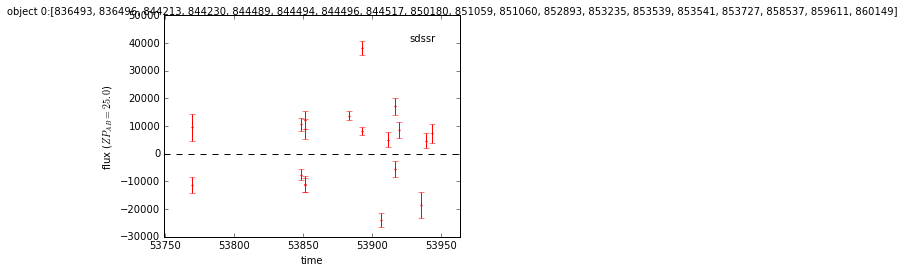

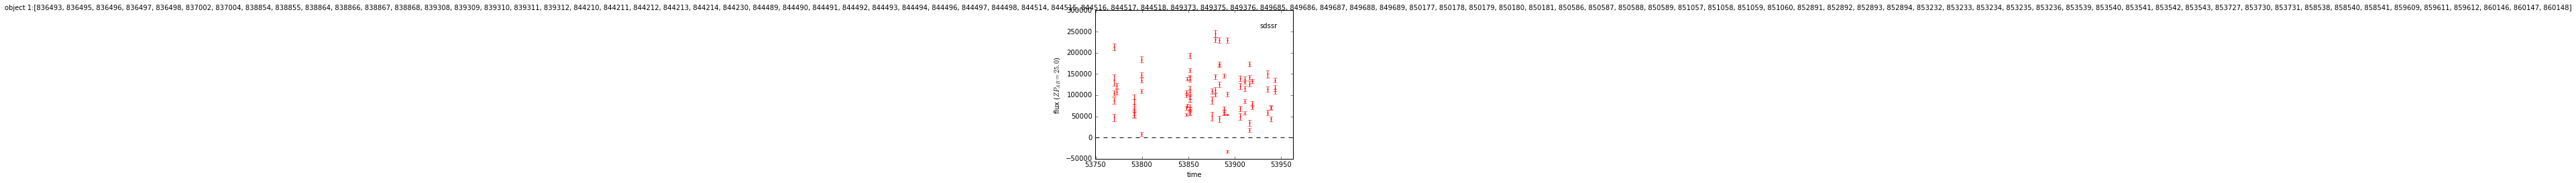

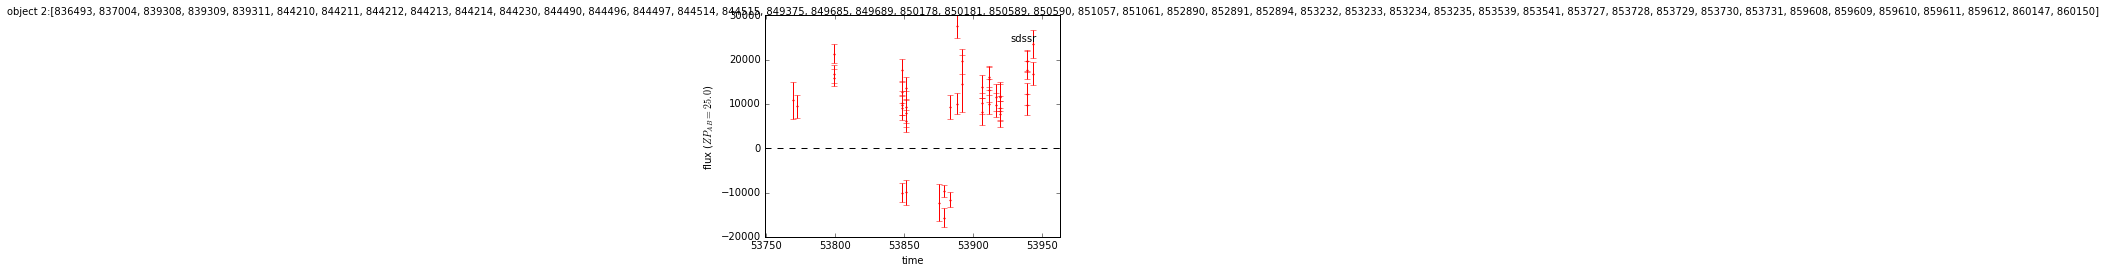

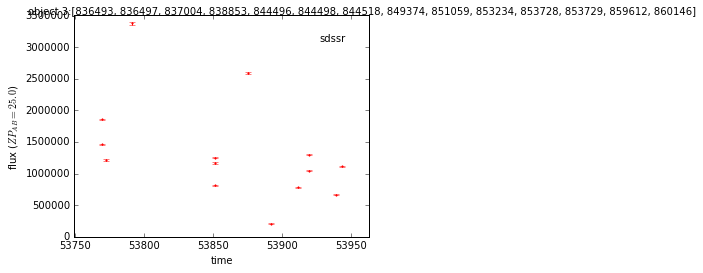

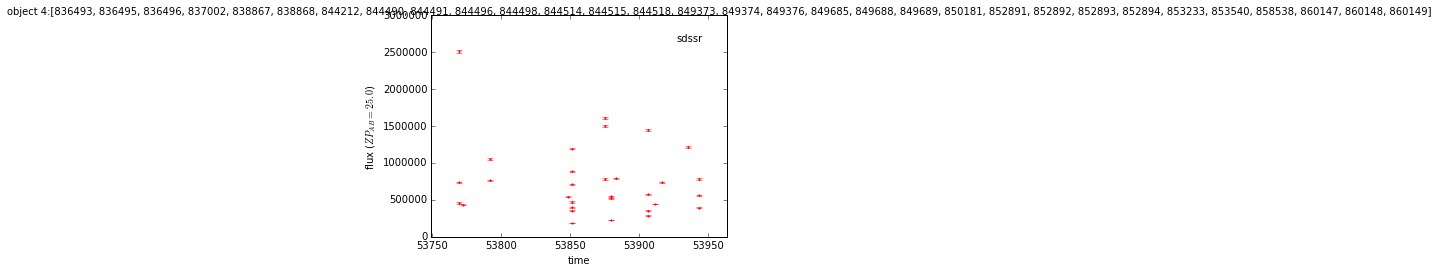

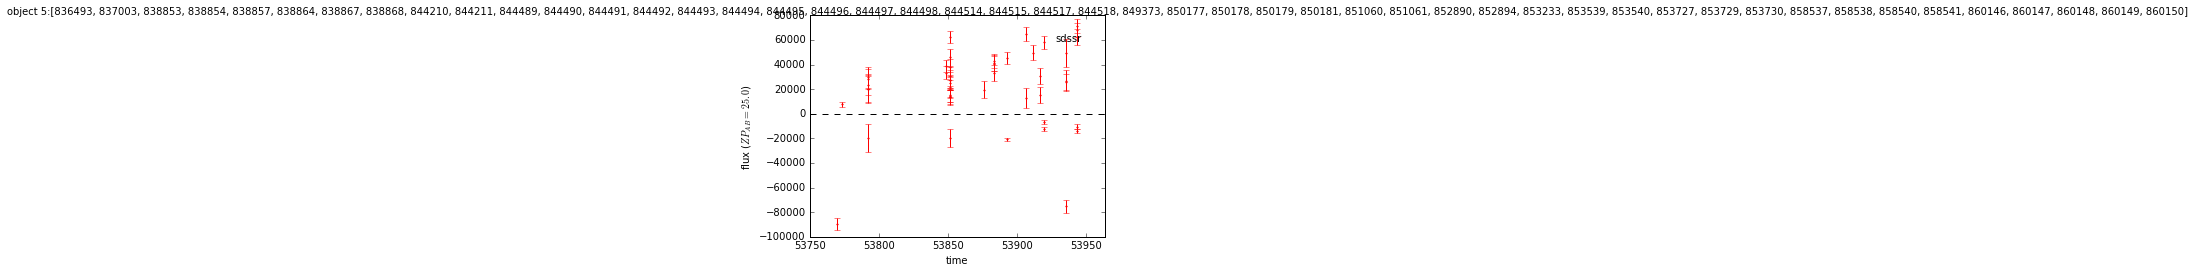

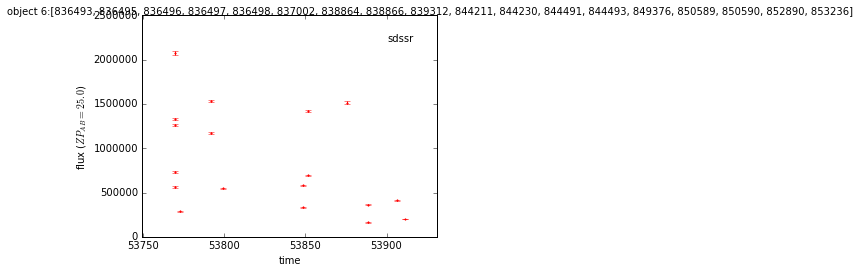

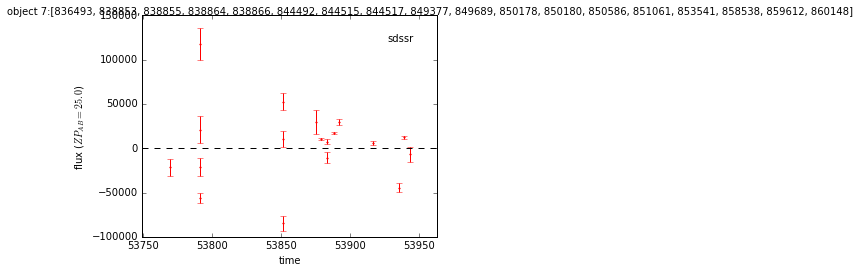

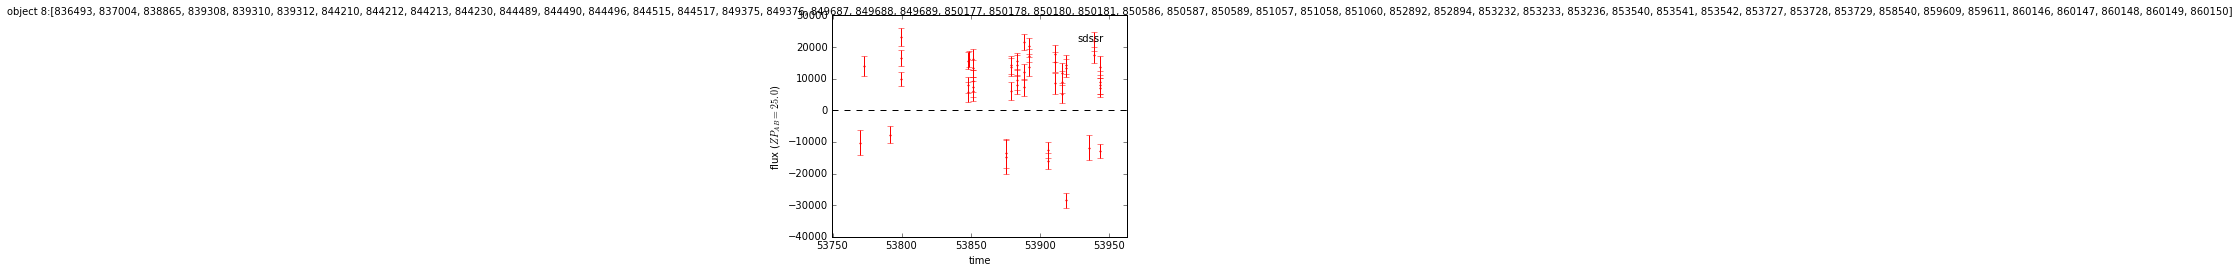

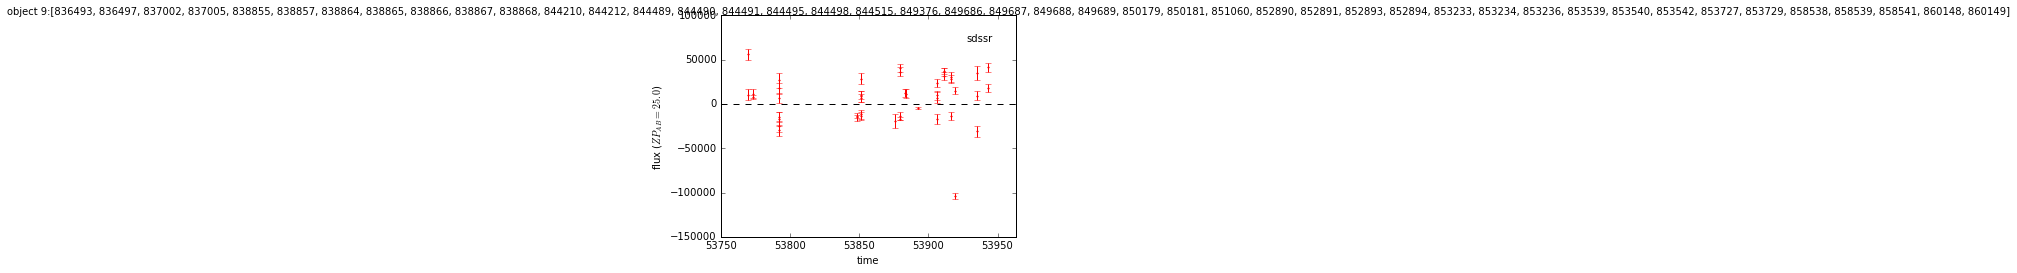

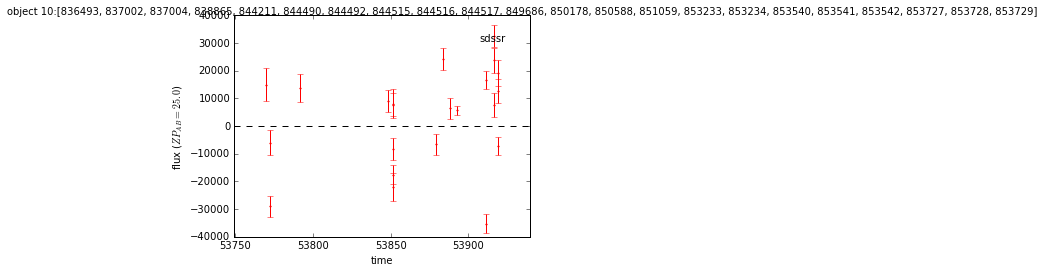

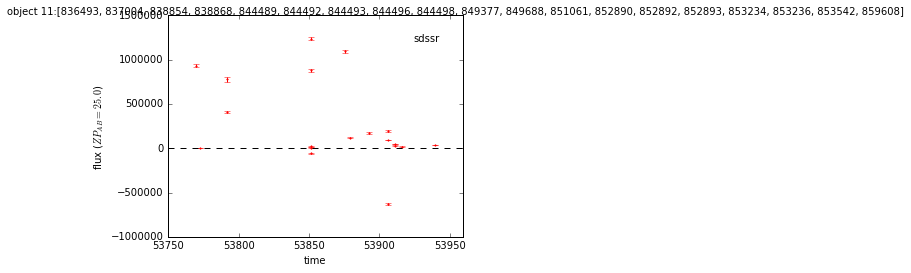

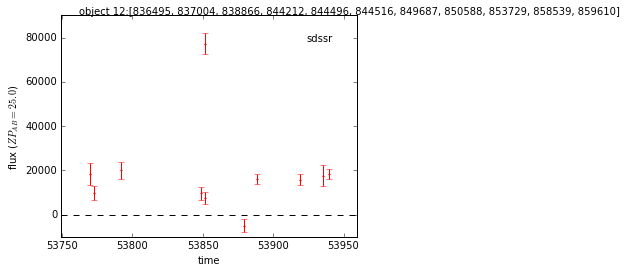

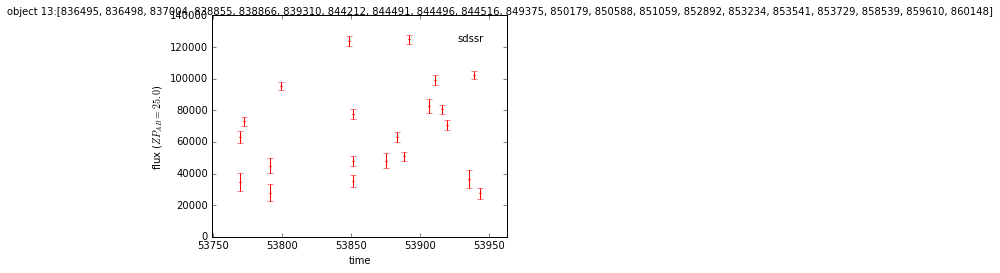

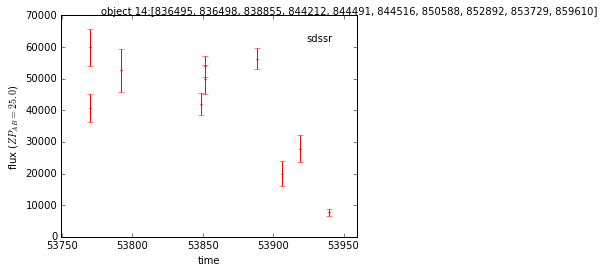

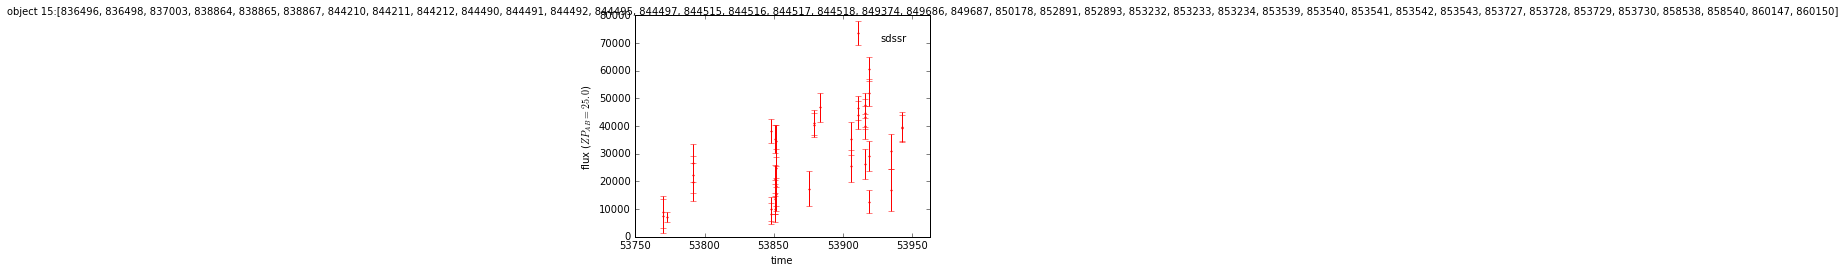

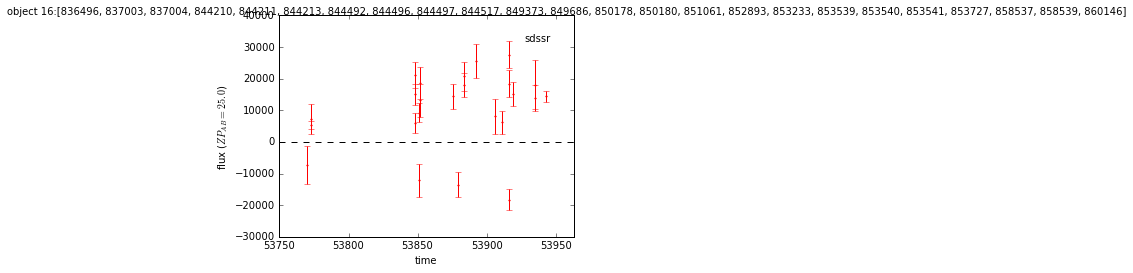

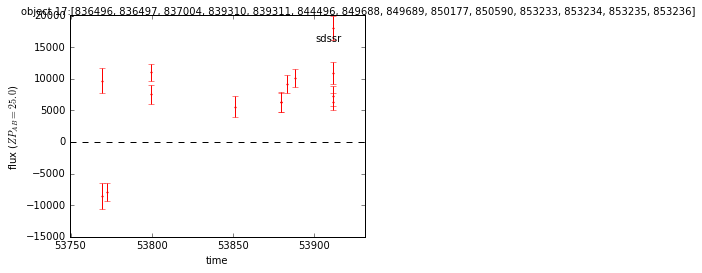

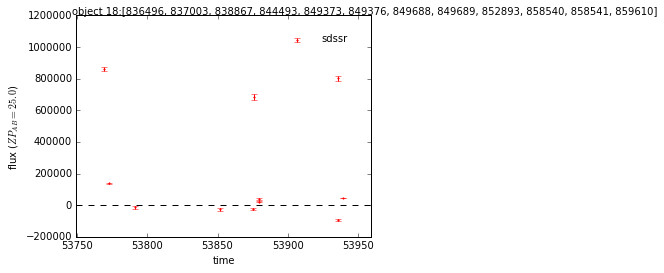

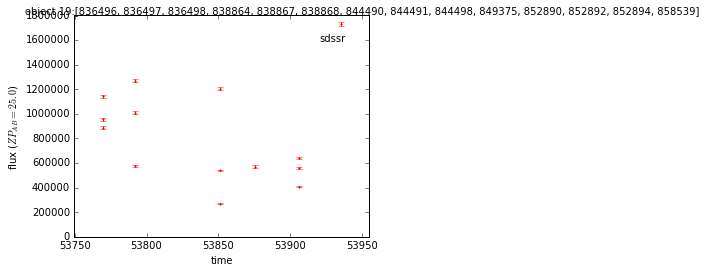

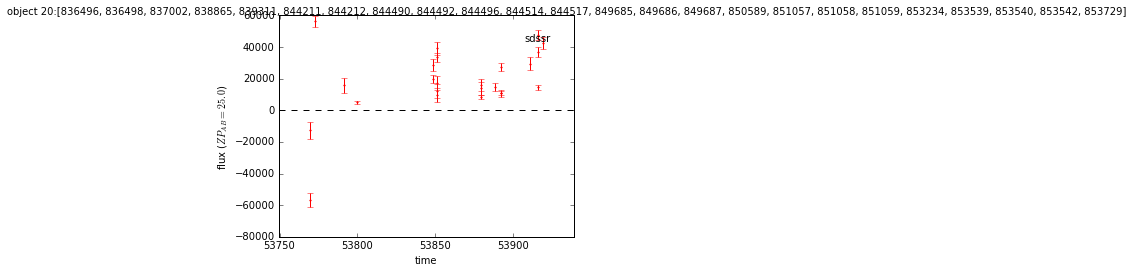

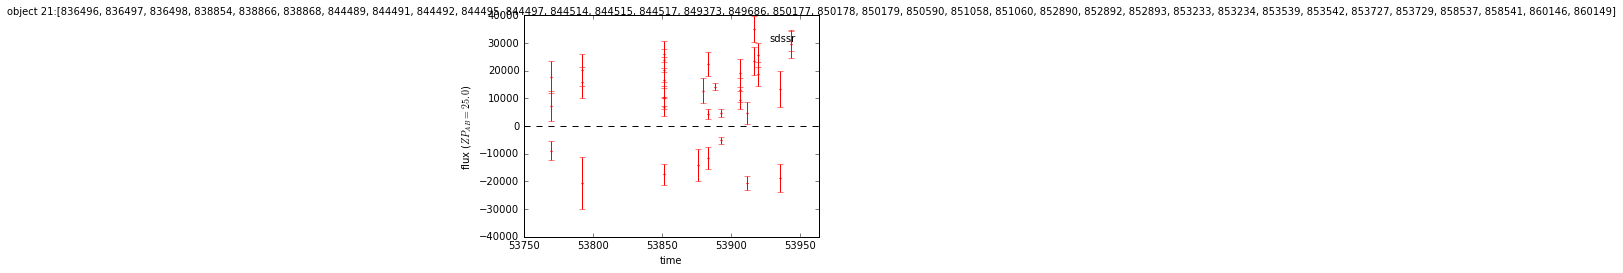

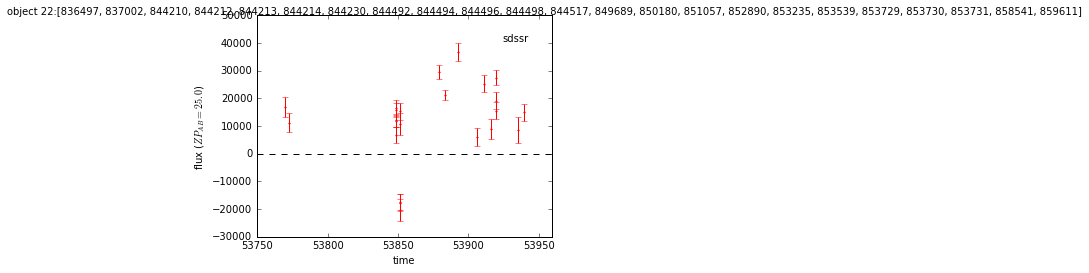

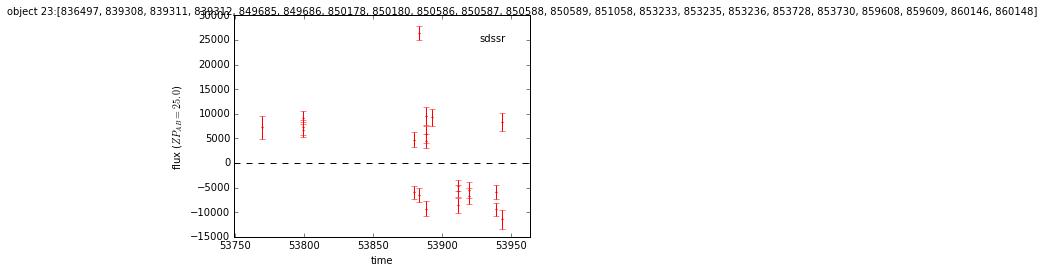

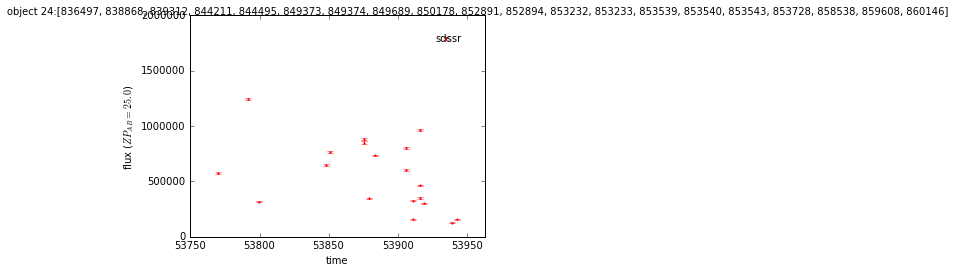

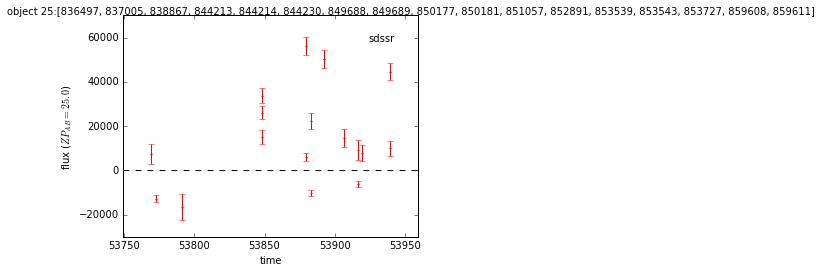

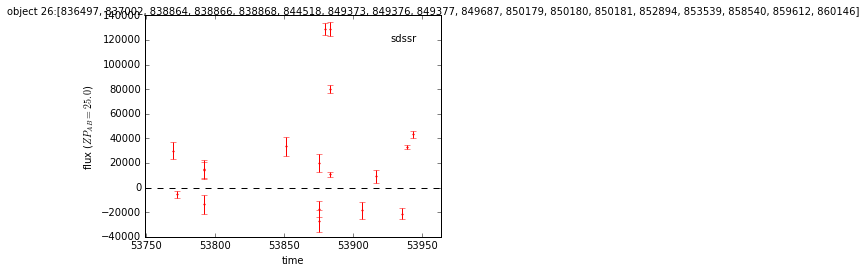

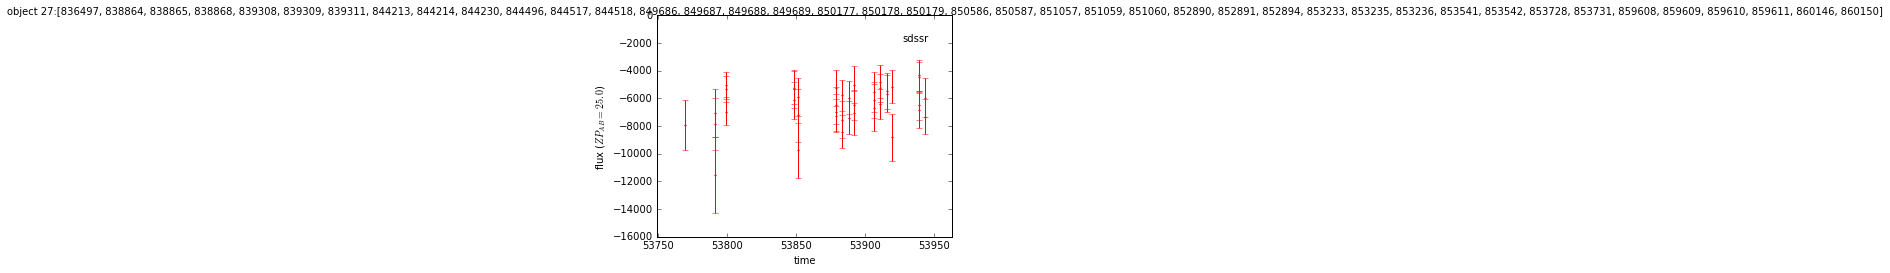

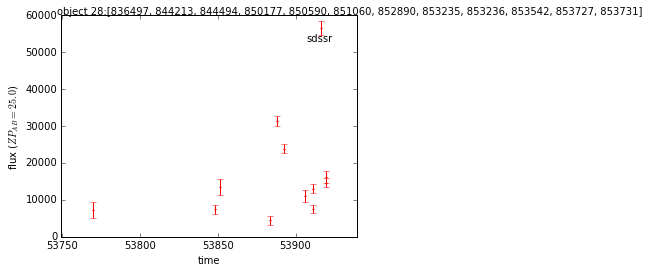

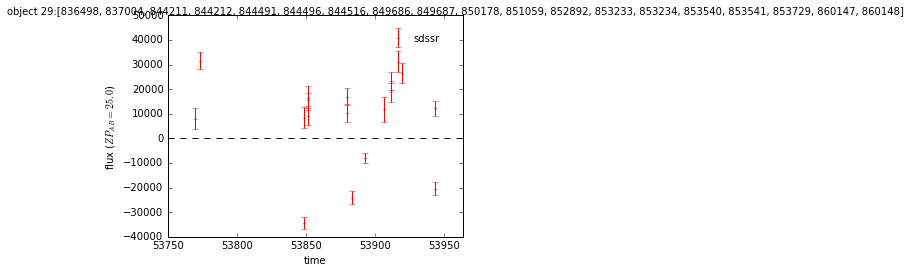

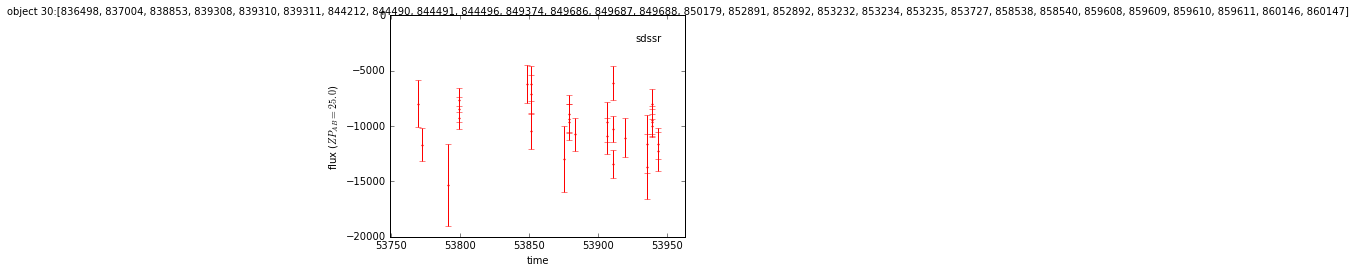

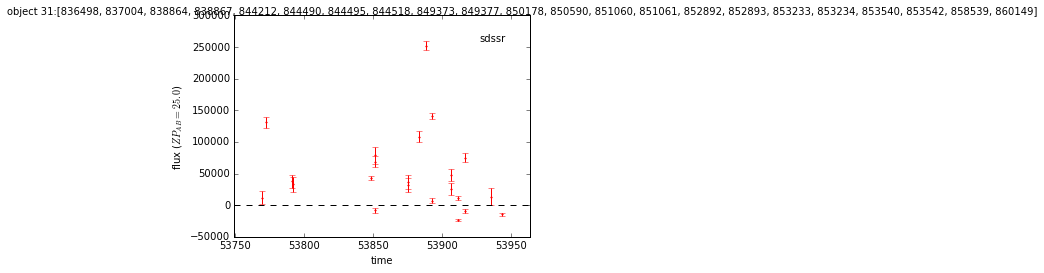

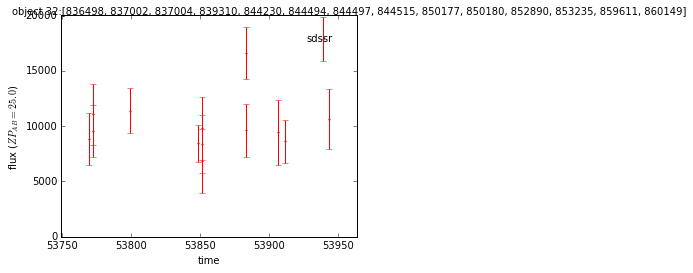

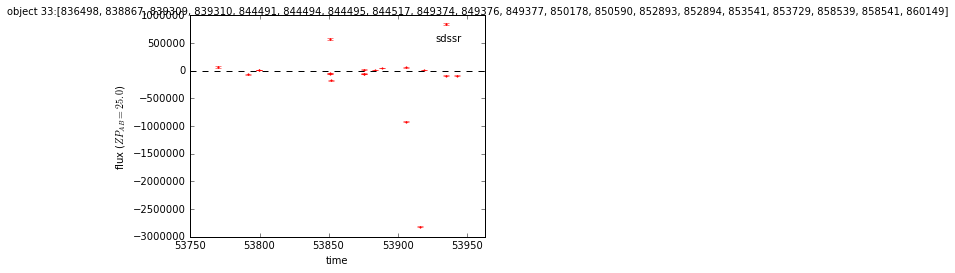

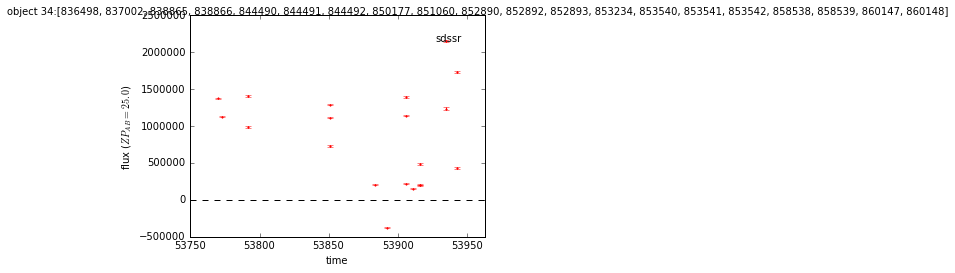

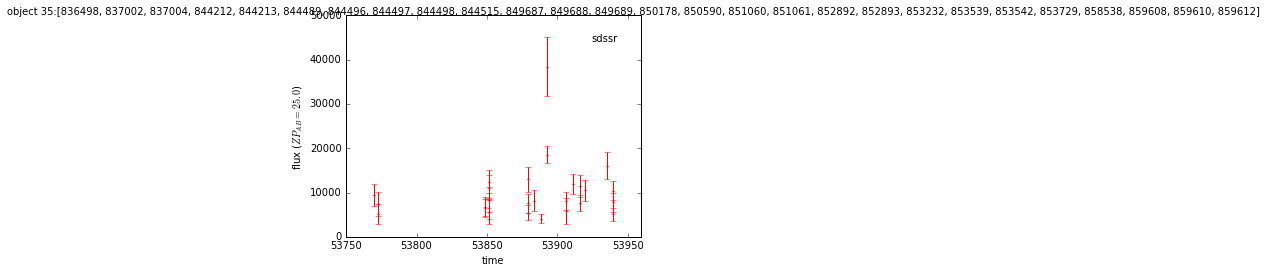

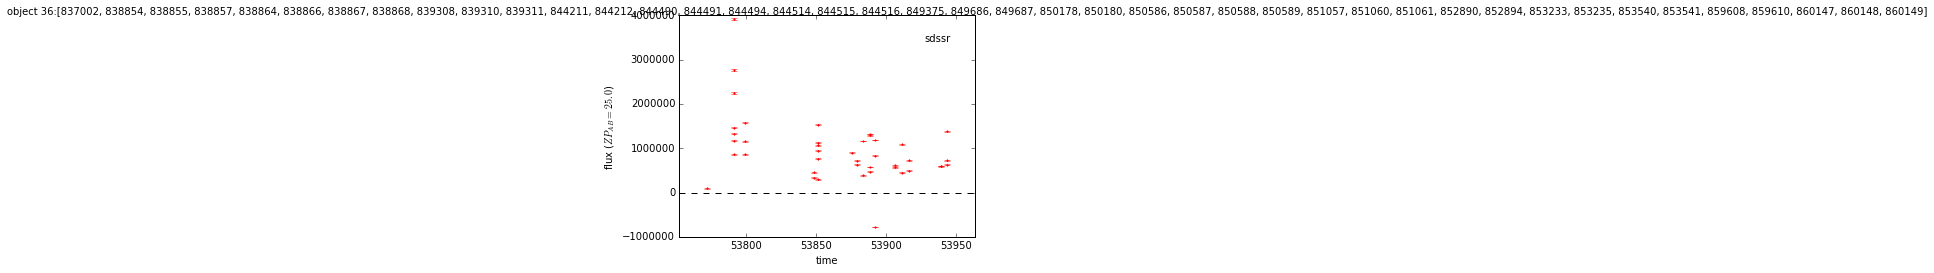

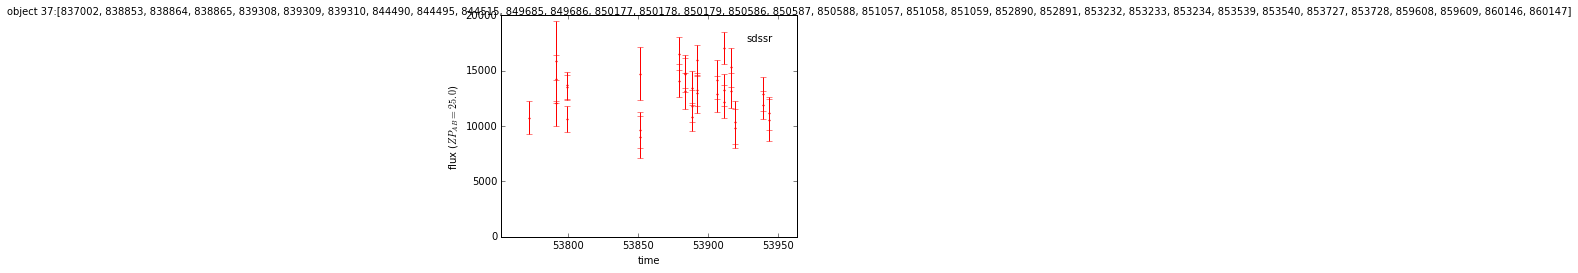

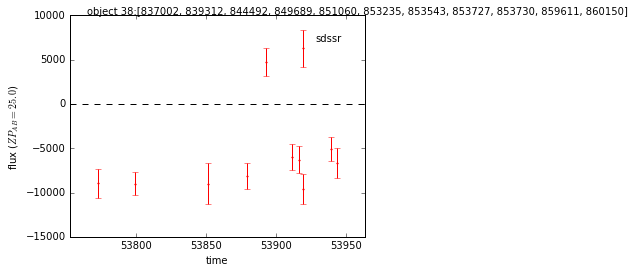

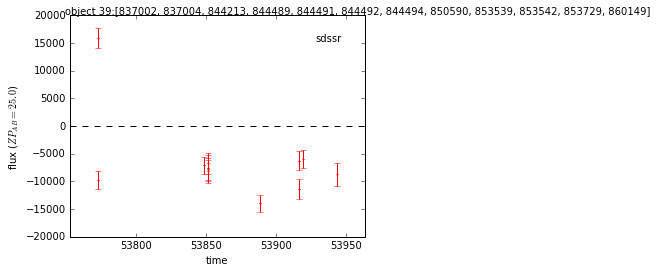

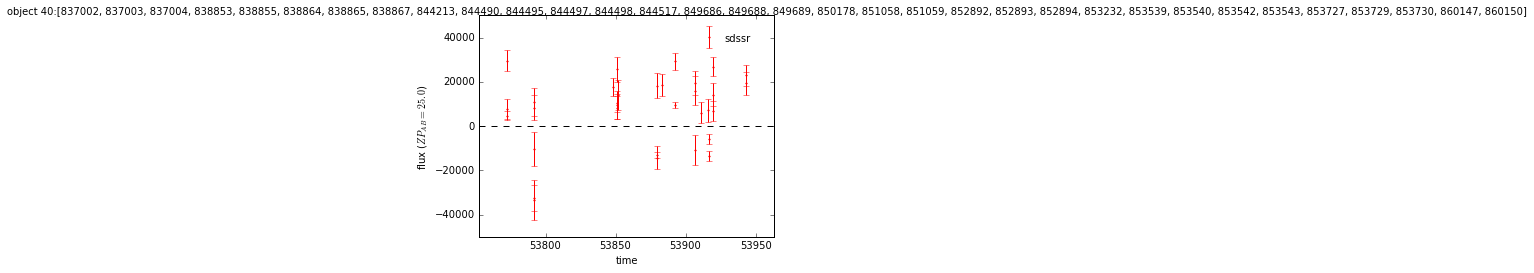

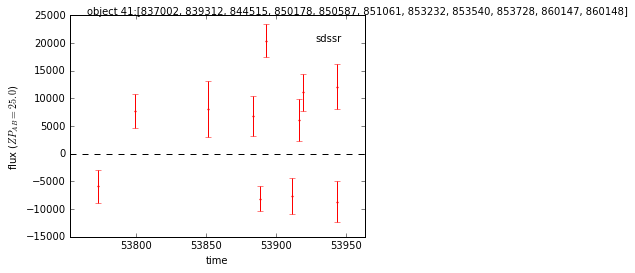

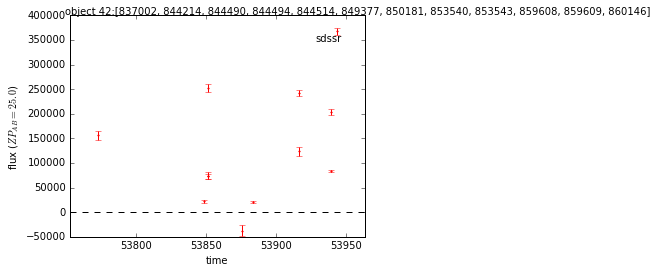

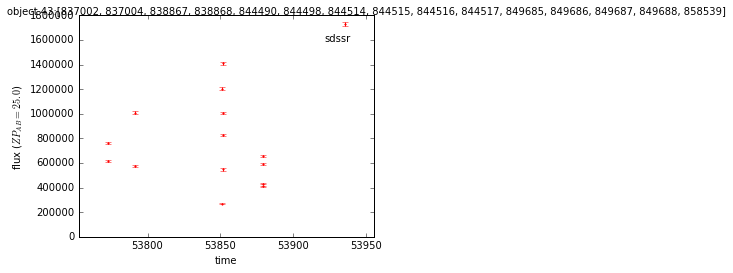

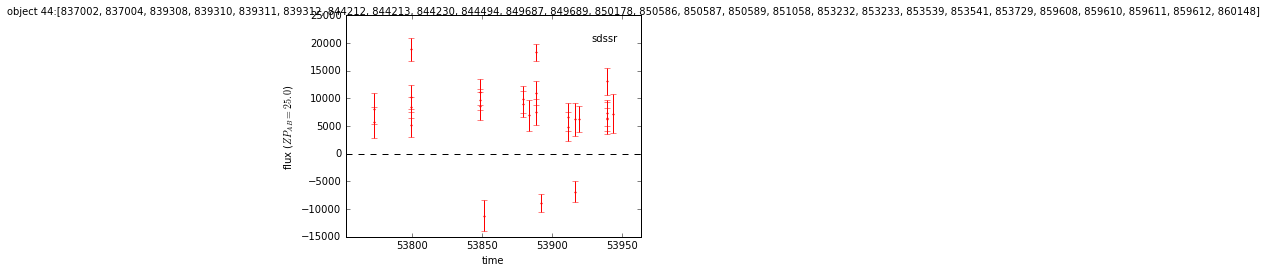

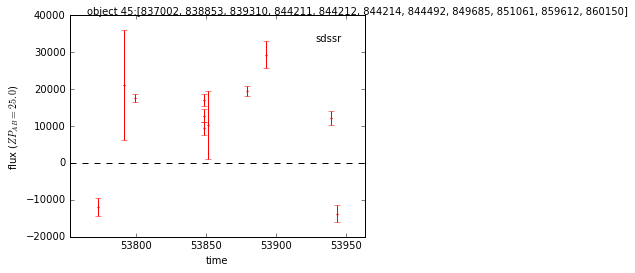

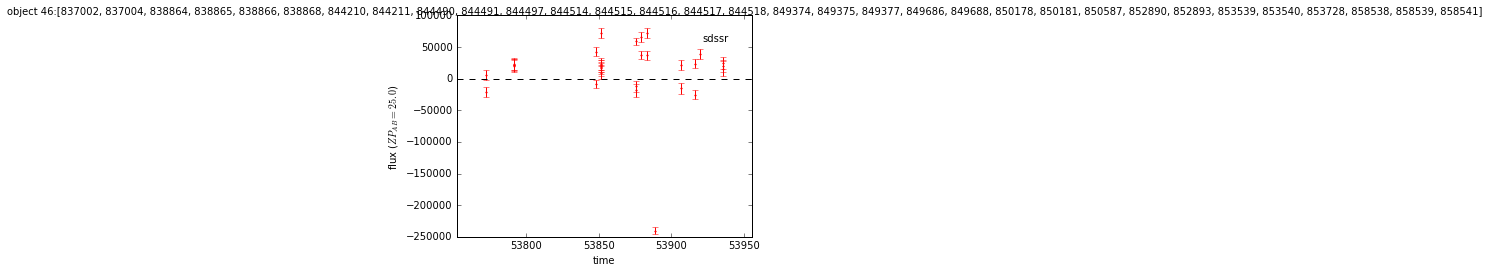

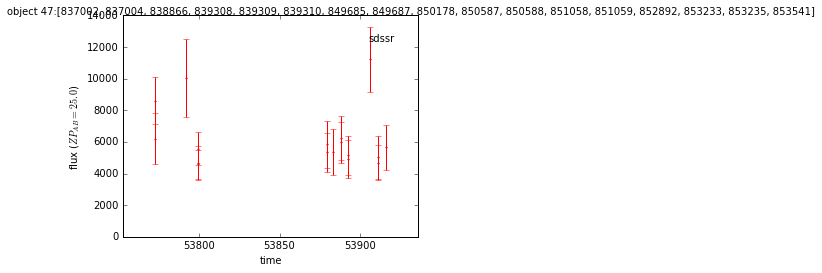

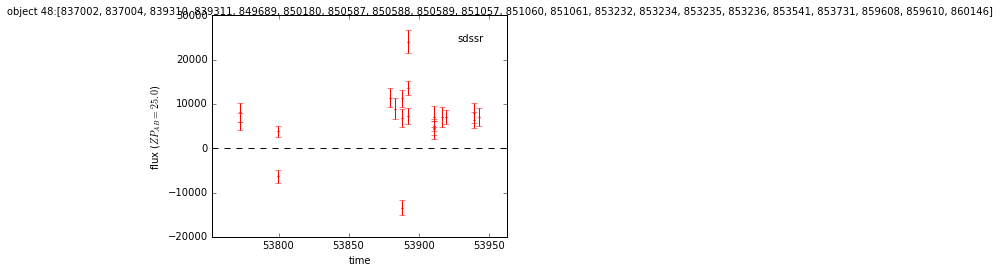

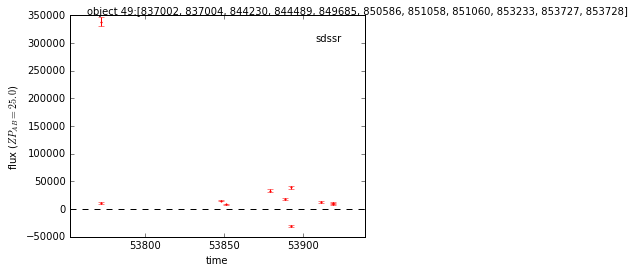

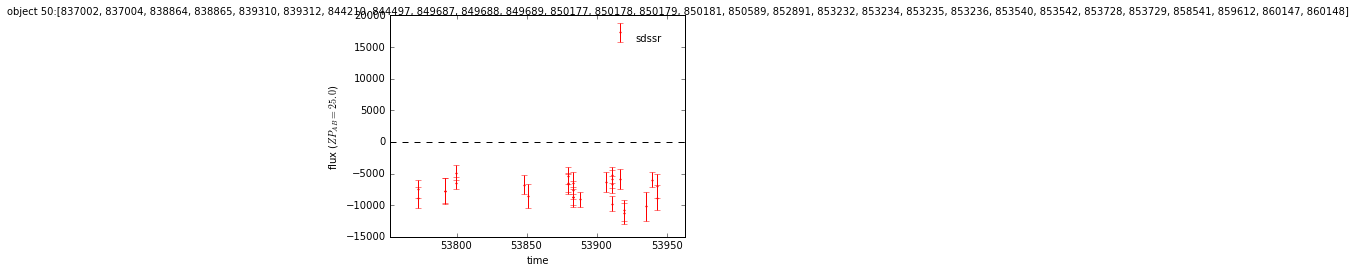

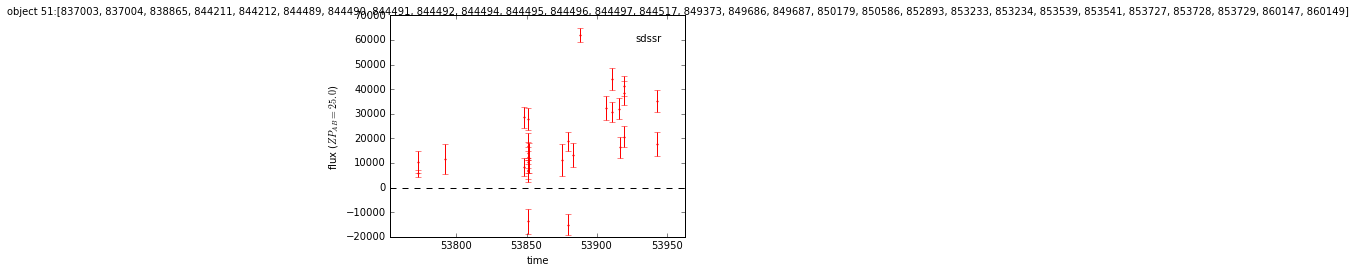

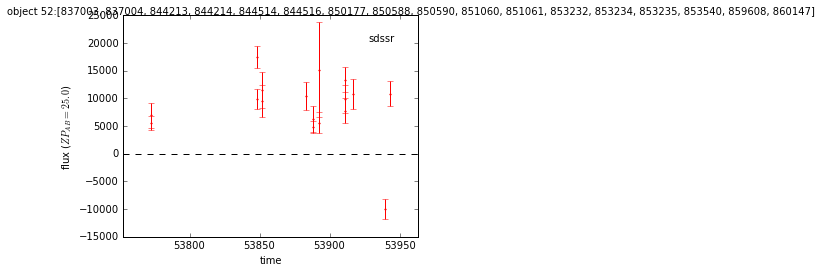

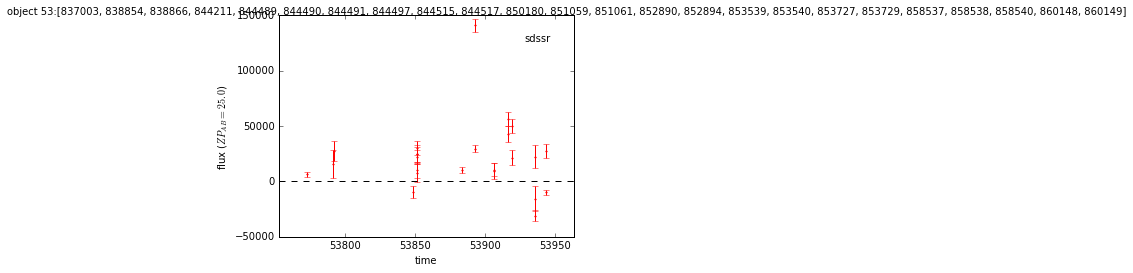

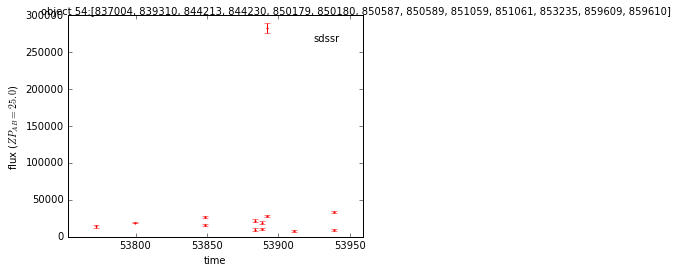

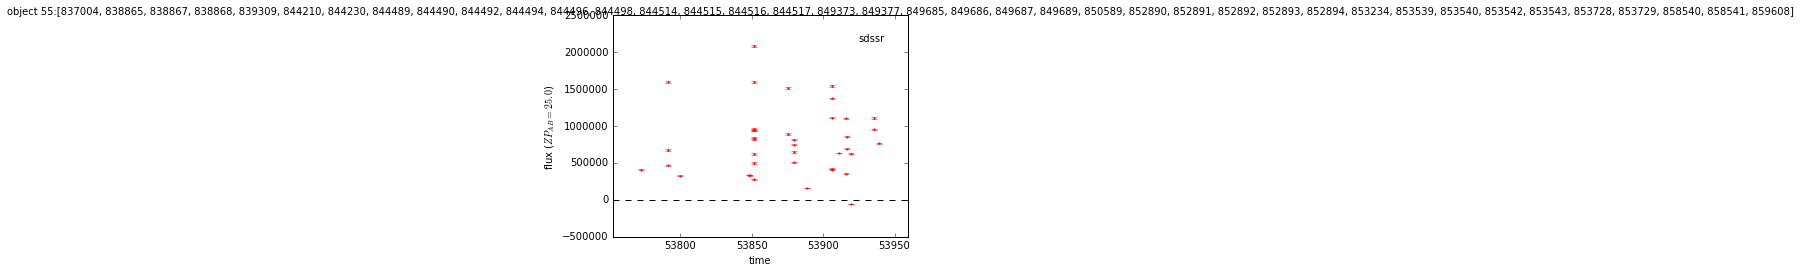

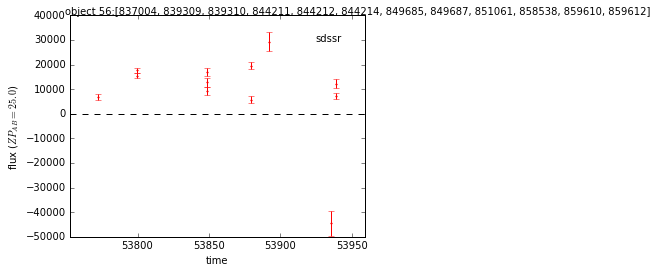

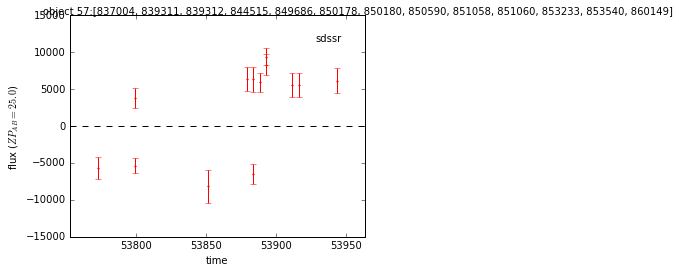

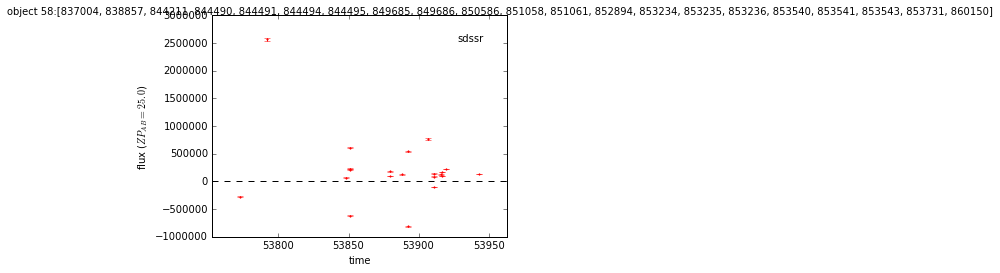

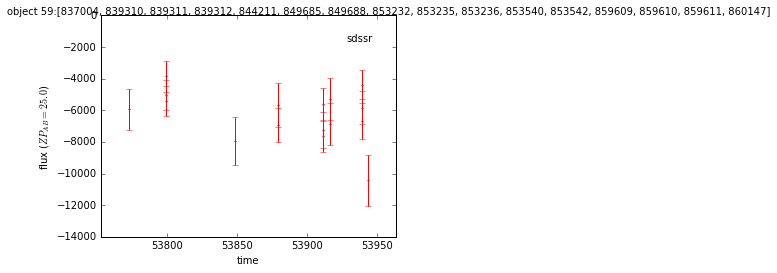

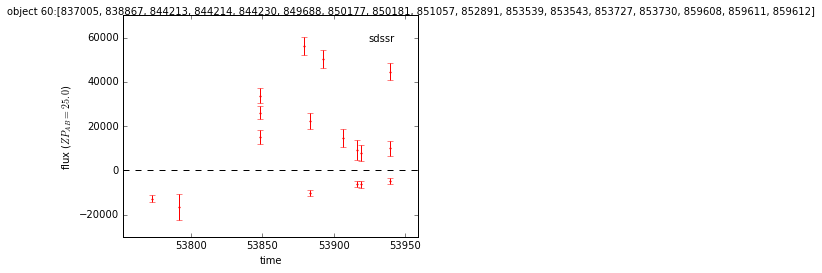

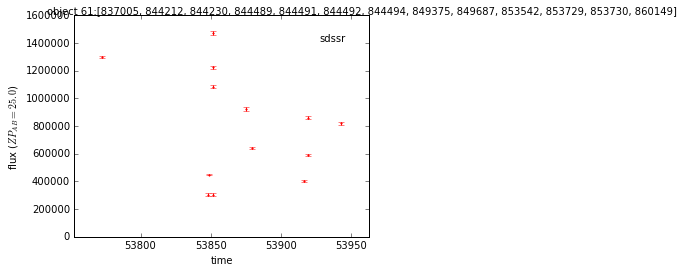

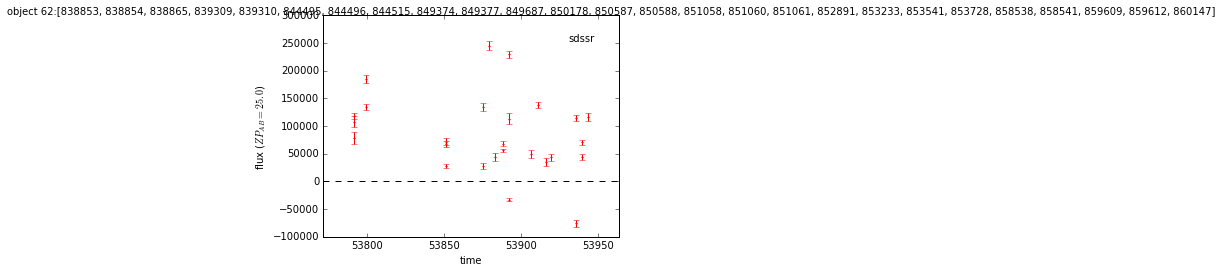

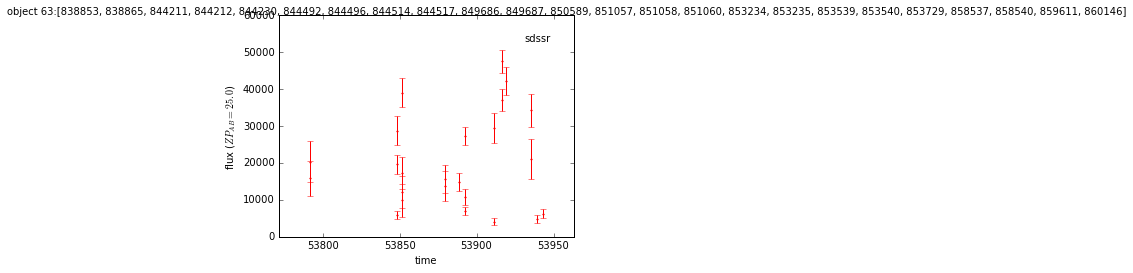

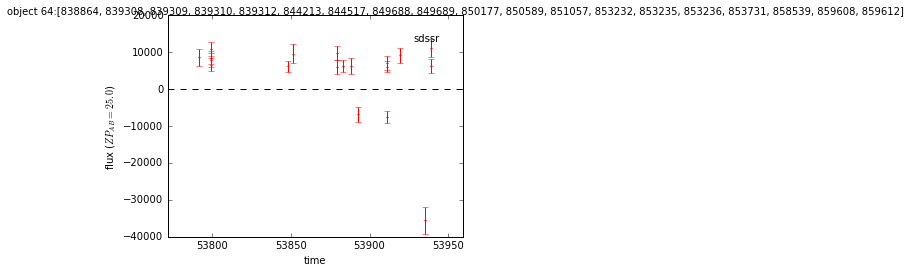

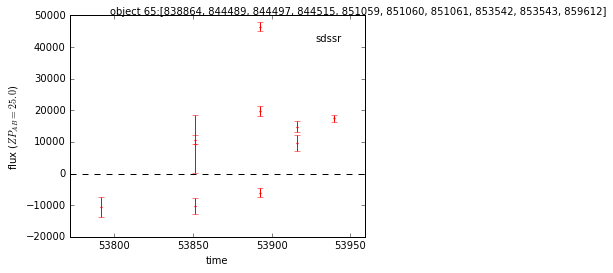

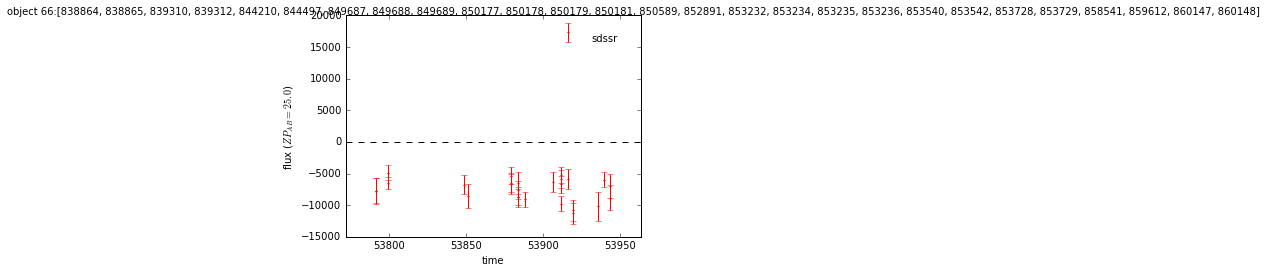

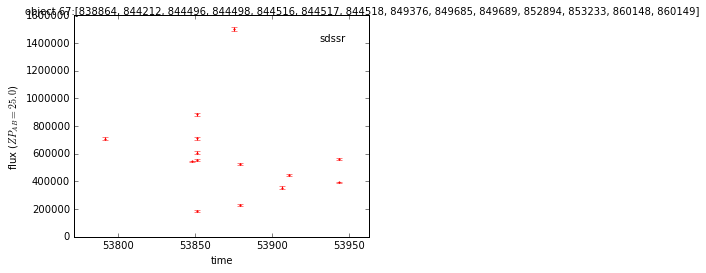

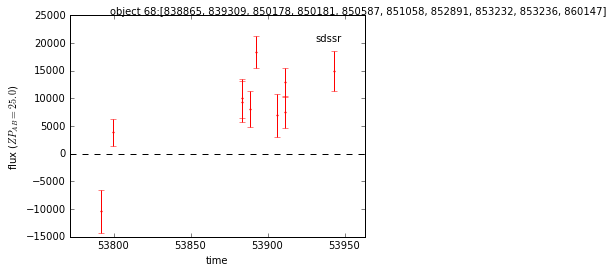

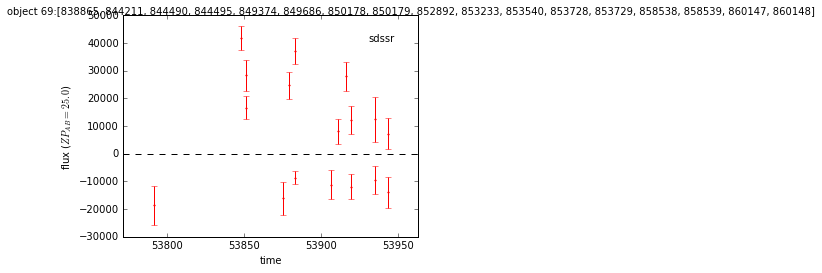

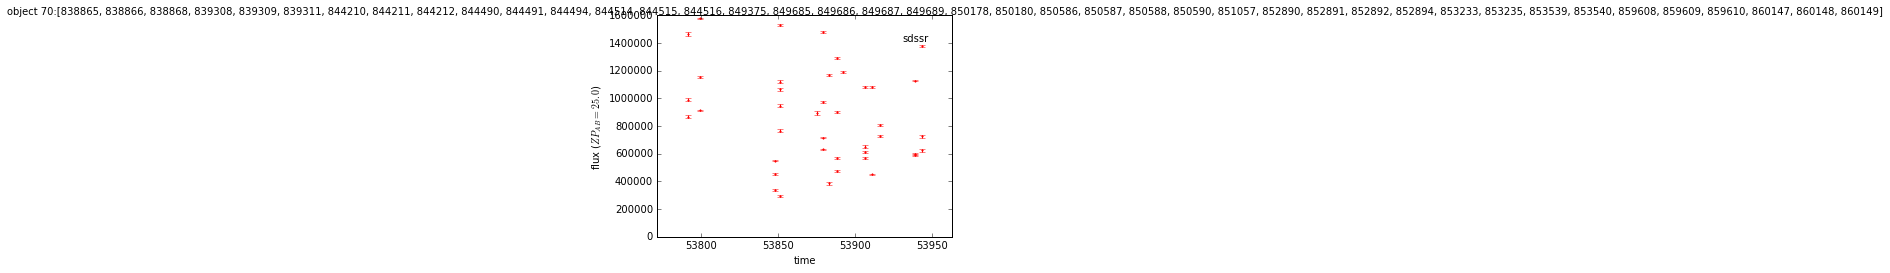

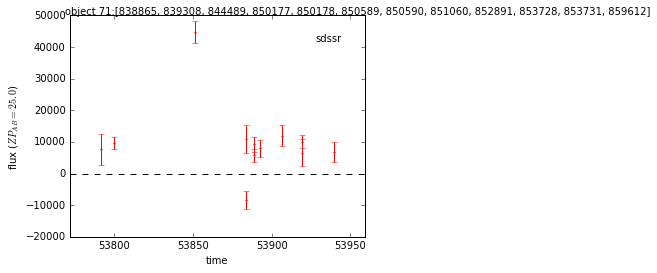

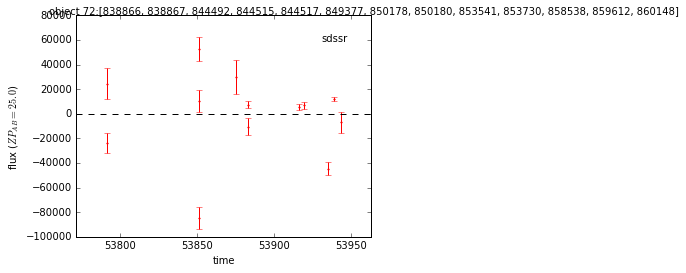

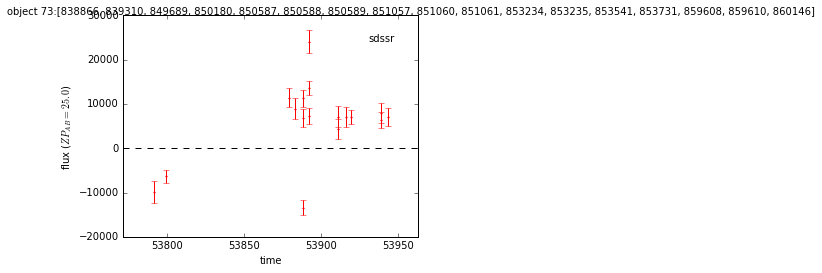

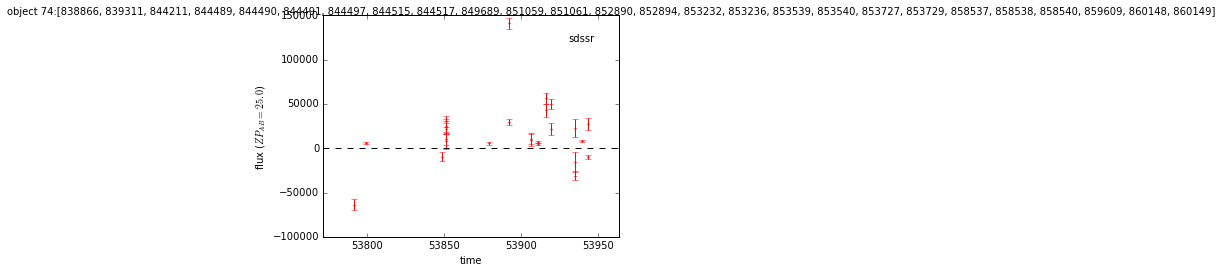

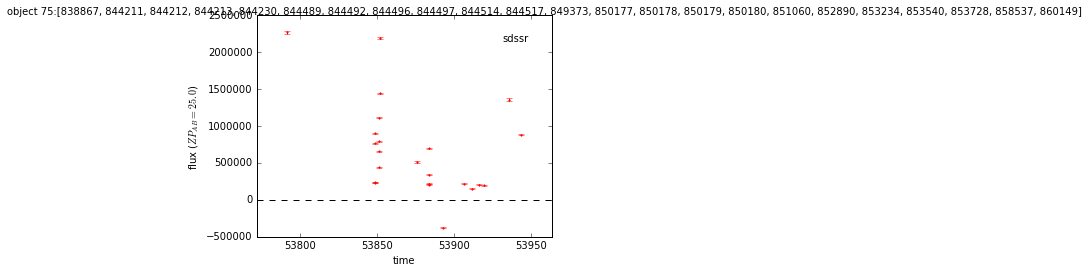

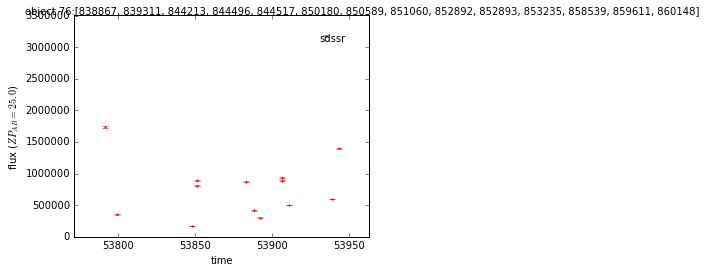

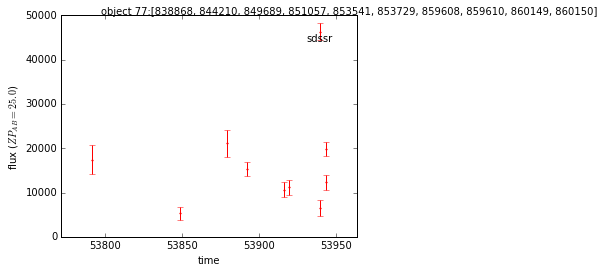

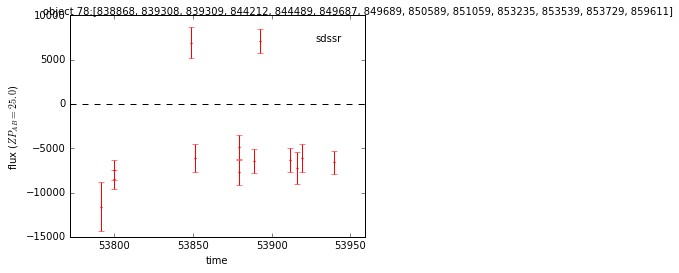

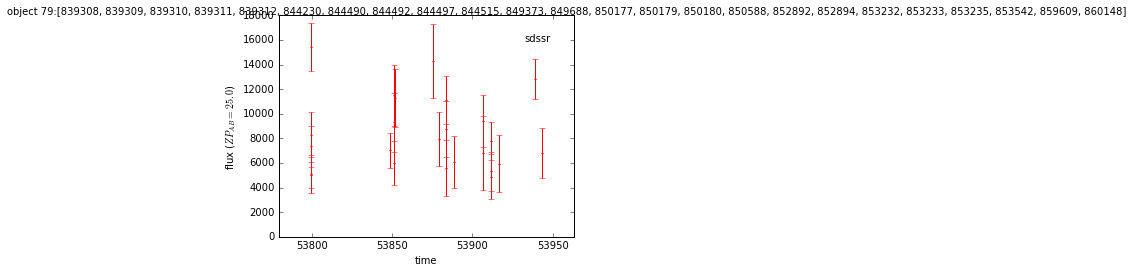

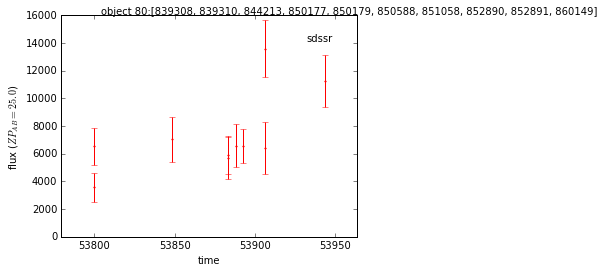

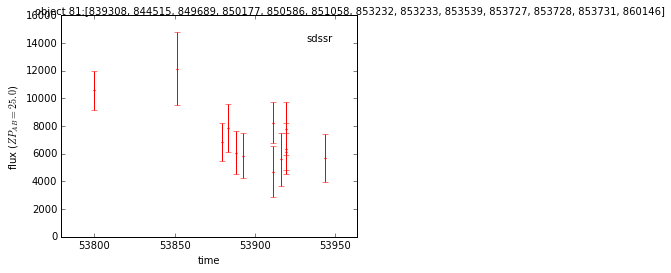

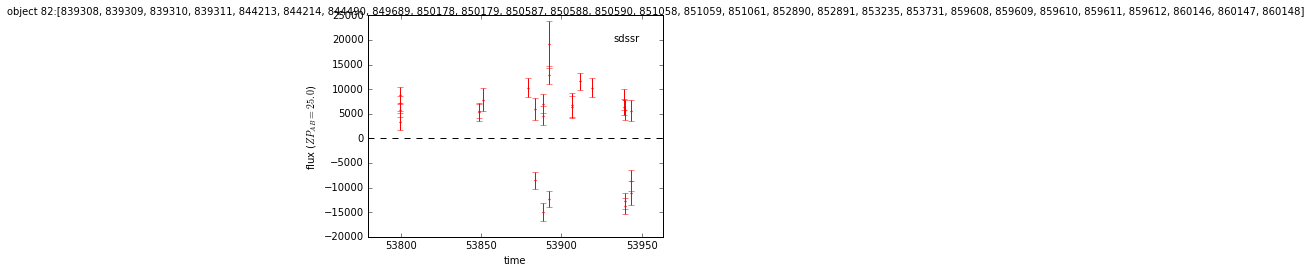

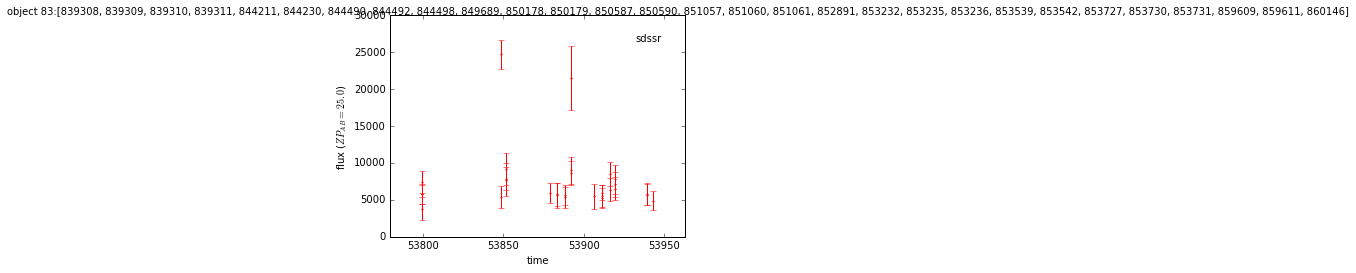

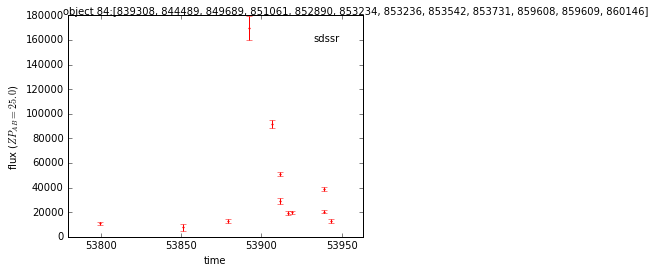

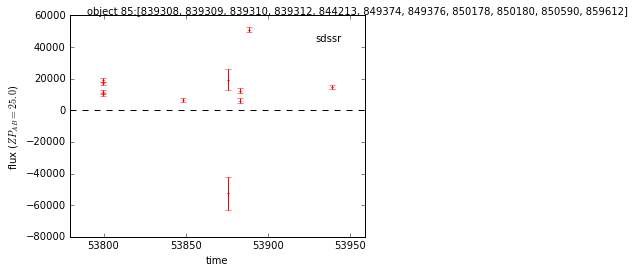

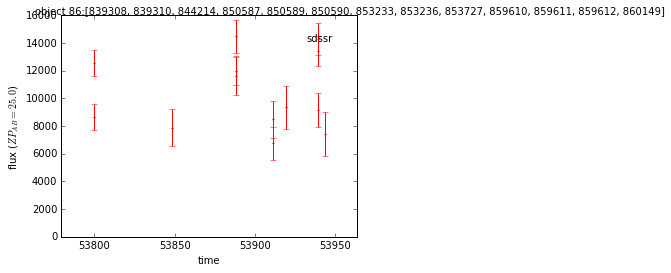

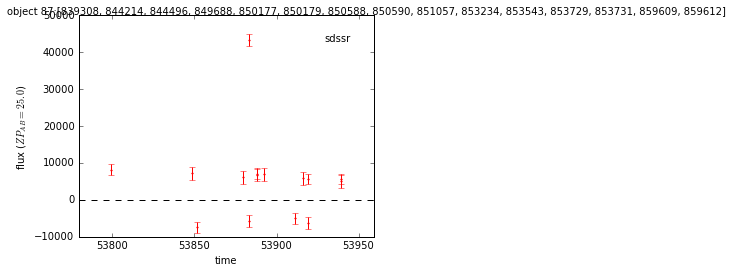

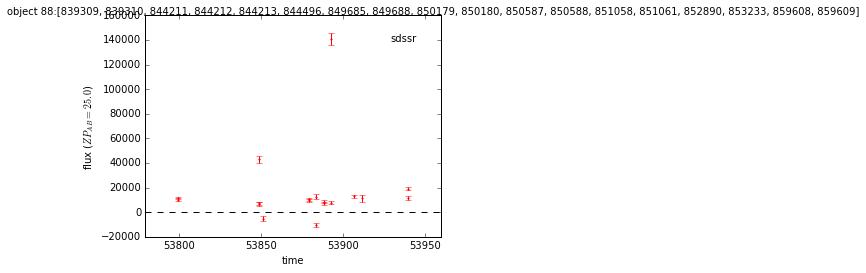

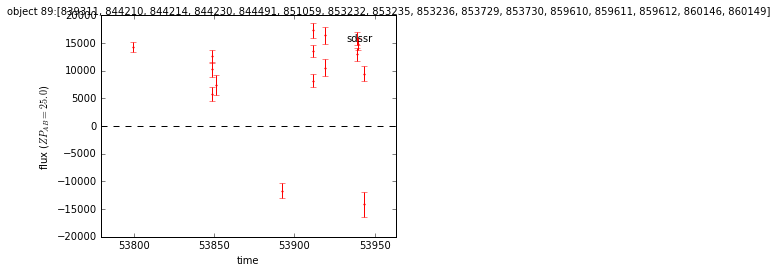

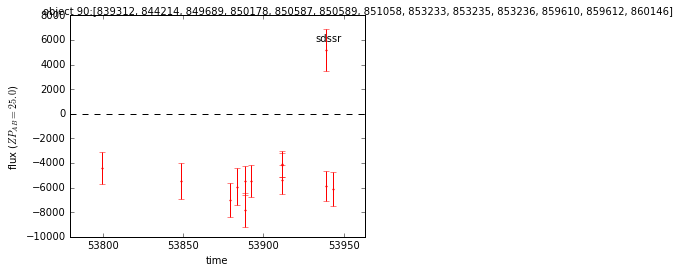

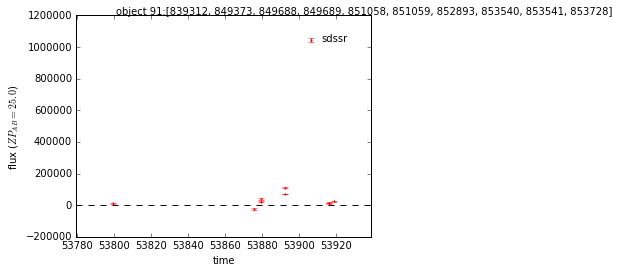

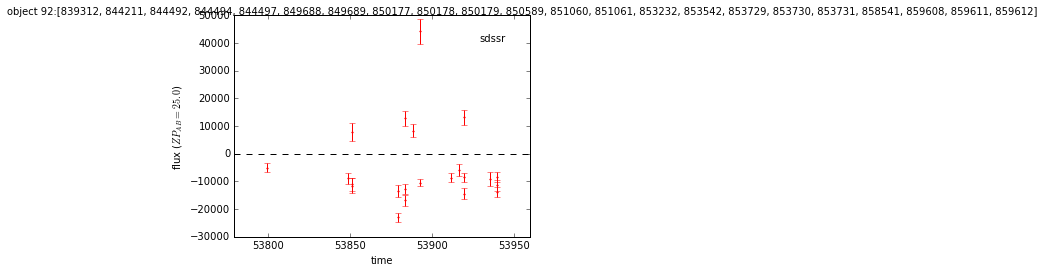

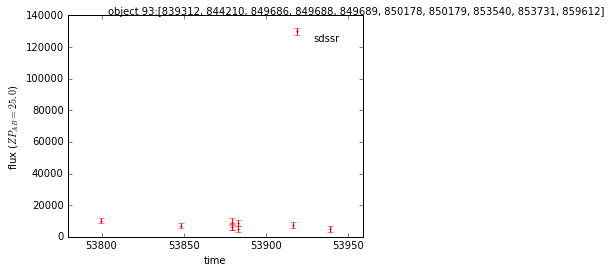

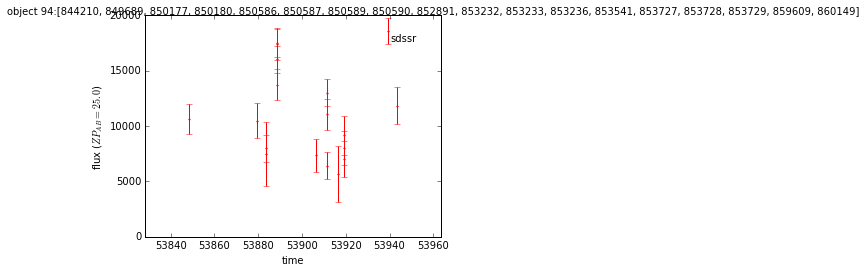

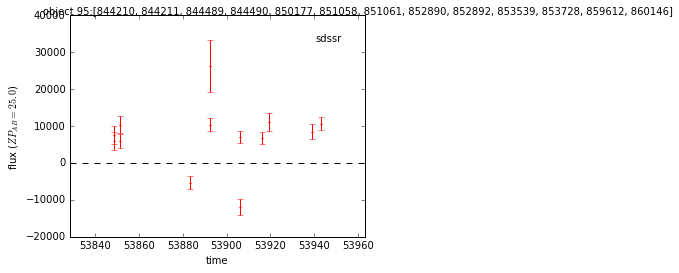

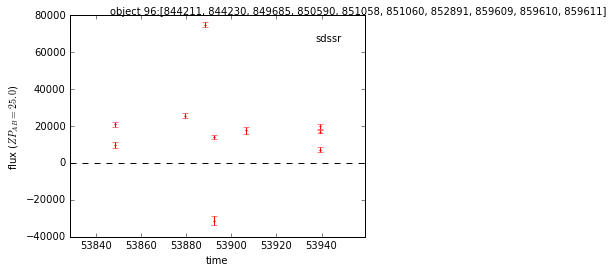

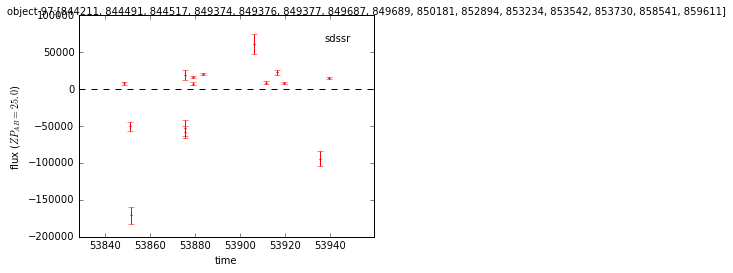

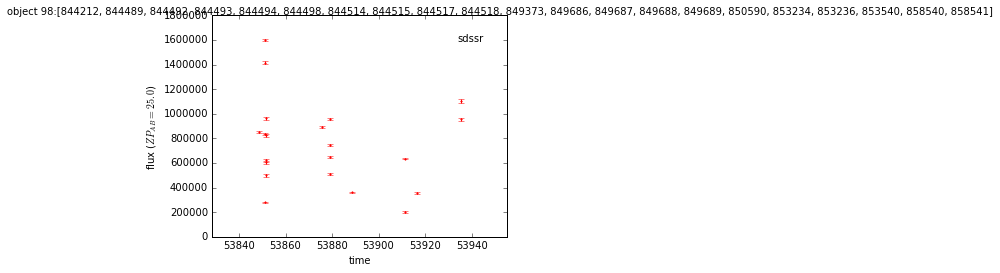

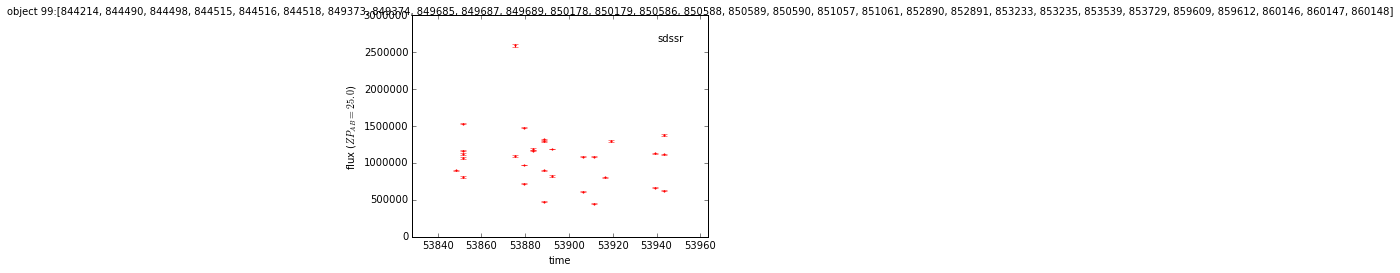

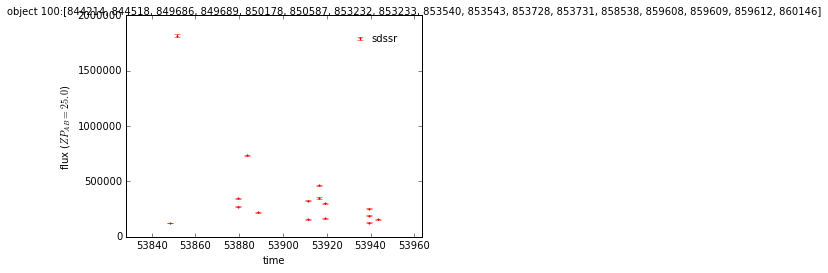

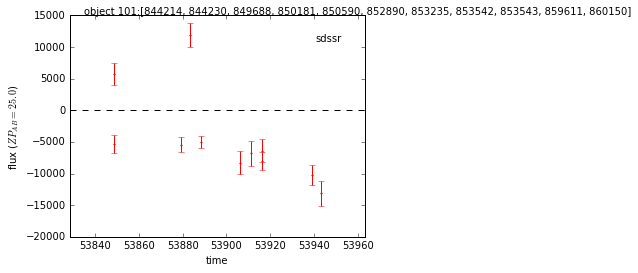

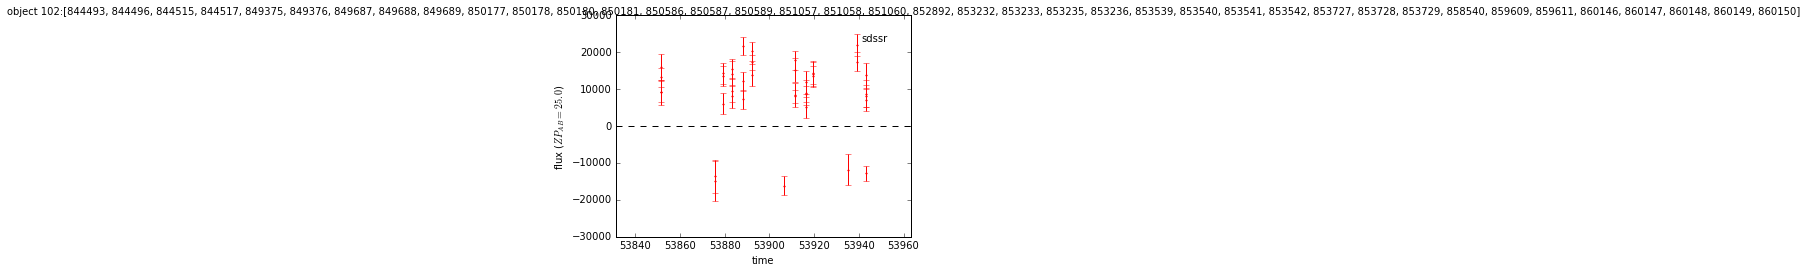

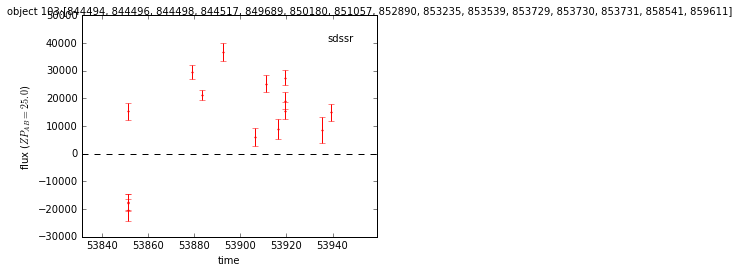

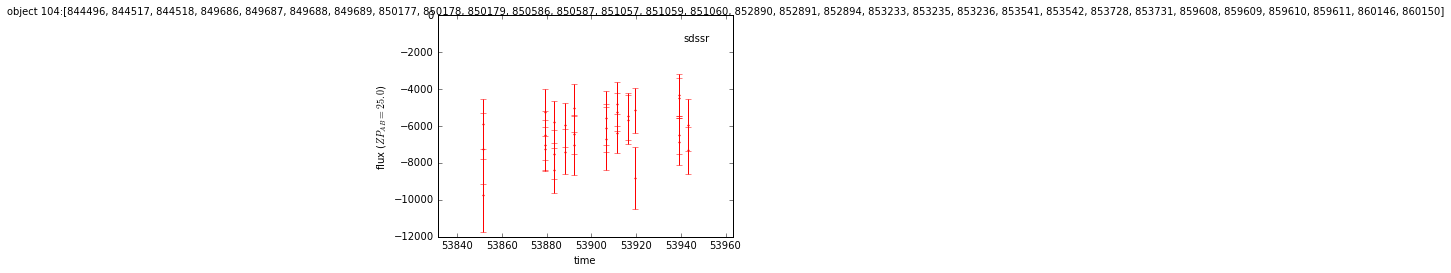

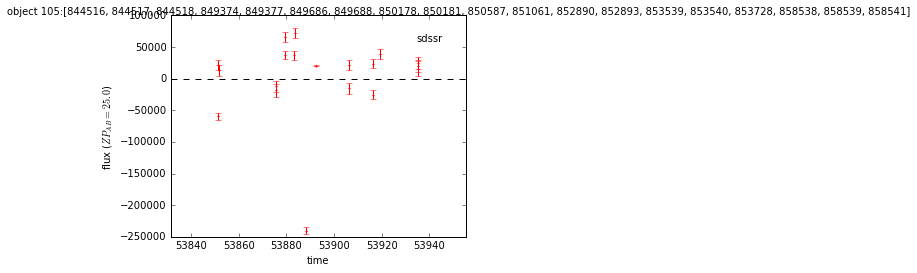

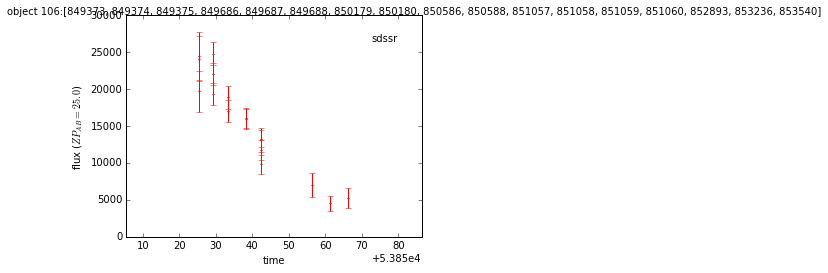

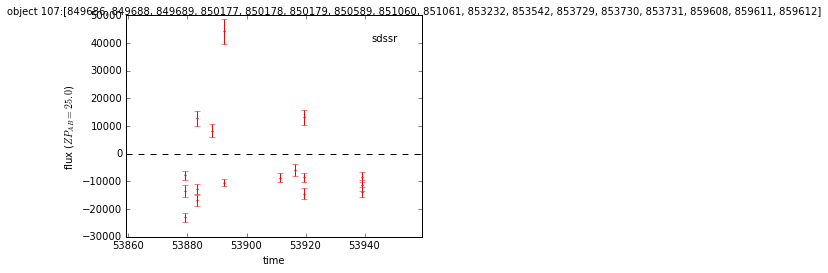

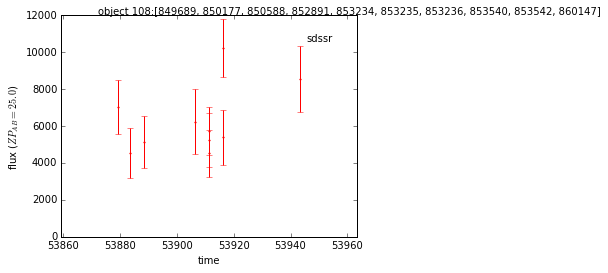

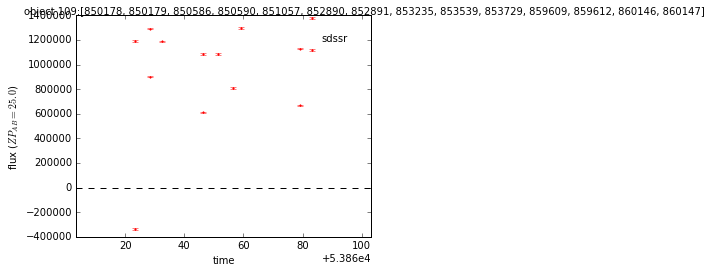

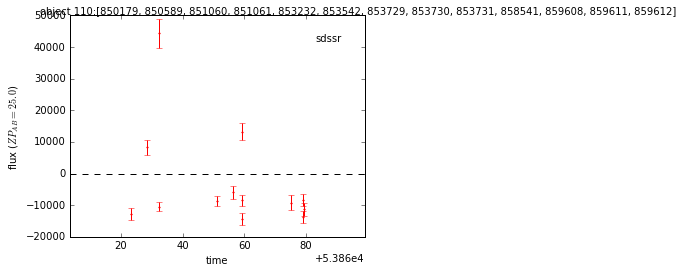

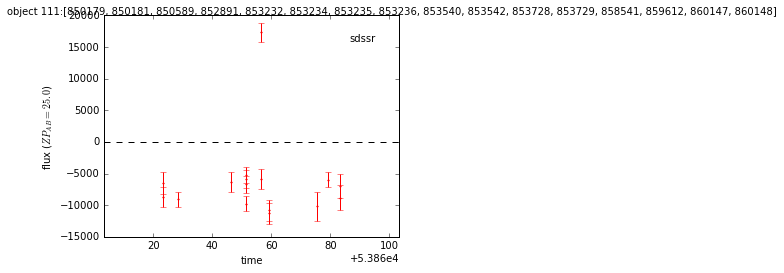

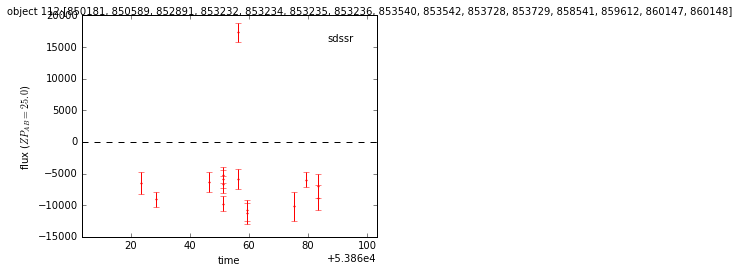

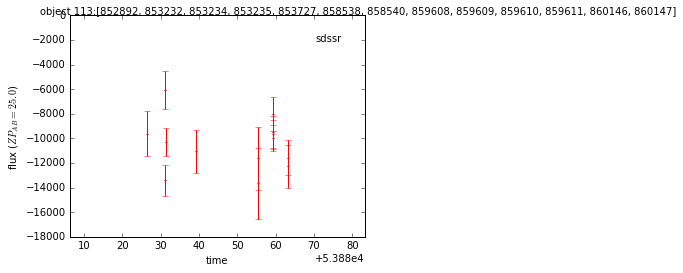

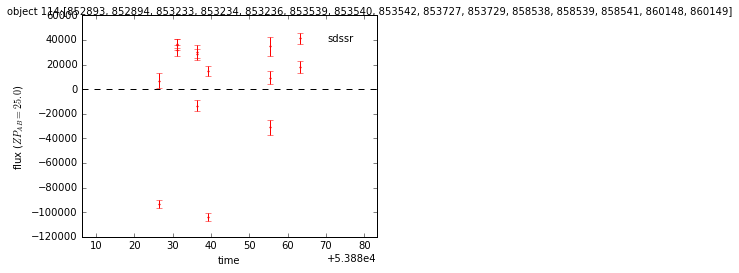

In [87]:
light_curves = []
i = 0
current = -1
while i < len(results):
    result = results[i]
    if current == -1 or current != result['object']:
        lc = [((result['visit'],result['day']),result)]
        light_curves.append(lc)
        current = result['object']
    else:
        light_curves[-1].append(((result['visit'],result['day']),result))
    i+=1
    
t_light_curves = threshold_light_curves(light_curves, 10)

for i, light_c in enumerate(t_light_curves):
    lc = build_lightcurve(light_c)
    
    lc_visits = [visit[0] for visit, data in light_c ]
    #print visits
    fig = sncosmo.plot_lc(lc, color='red', xfigsize=10)
    axes = fig.get_axes()
    xlim = axes[0].get_xlim()
    axes[0].set_xlim(xlim[0]-10, xlim[1]+10)
    fig.suptitle("object "+str(i)+":"+str(lc_visits))
    fig.show()  

In [40]:
light_curves[-1]

[((860146, 174),
  <lsst.afw.table.tableLib.SourceRecord; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::table::SourceRecord > *' at 0x7ff3e2df1a50> >)]

In [ ]:
for r in results:
    print r['object'], r['visit'], r['days']

In [102]:
test = get_diaSource_input_on_ccd(butler, visits, 14)

In [103]:
len(test)

115

In [ ]:

subtr_visits = get_diaSource_input_on_ccd(butler, visits, 14)
        
paired_matches = find_paired_matches(subtr_visits)
light_curves = create_light_curves(paired_matches)
#light_curves = fill_gaps_on_curves(light_curves)

t_light_curves = threshold_light_curves(light_curves, 3)

for i, light_c in enumerate(t_light_curves):
    lc = build_lightcurve(light_c)
    
    lc_visits = [visit[0] for visit, data in light_c ]
    #print visits
    fig = sncosmo.plot_lc(lc, color='red', xfigsize=10)
    axes = fig.get_axes()
    xlim = axes[0].get_xlim()
    axes[0].set_xlim(xlim[0]-10, xlim[1]+10)
    fig.suptitle("object "+str(i)+":"+str(lc_visits))
    fig.show()


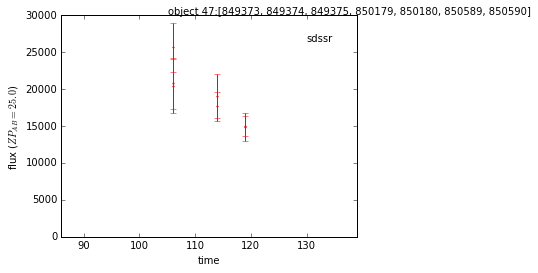

In [84]:
lc = build_lightcurve(t_light_curves[41])
#visualize_lightcurve(lc, color='red')
lc_visits = [visit[0] for visit, data in t_light_curves[41] ]
#print visits
fig = sncosmo.plot_lc(lc, color='red', xfigsize=10)
axes = fig.get_axes()
xlim = axes[0].get_xlim()
axes[0].set_xlim(xlim[0]-10, xlim[1]+10)
fig.suptitle("object "+str(i)+":"+str(lc_visits))
fig.show()

In [76]:
i = 1
for tl in t_light_curves:
    try:
        dataid_list = [{'visit': visit[0] , 'filter':'r' , 'ccd':14}  for visit, data in tl]
        source = tl[0][-1]
        DSTools.get_time_mosaic(butler, dataid_list, source, frame=i, equalize=True, title="object n. "+str(i-1))
        ds9.setMaskTransparency(100, frame=i)
        i+=1
    except Exception, e:
        
        i+=1
        print e
    


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(321,4521),Extent2I(101,101)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(321,4521),Extent2I(101,101)) doesn't fit in image 2048x4612'



In [47]:
i=1
cl = butler.get('calexp', {'visit': 850177 , 'filter':'r' , 'ccd':14})
ds9.mtv(cl, frame=1)
for n, tl in enumerate(t_light_curves):
   
    source = tl[0][-1]
    wcs = cl.getWcs()
    x, y = wcs.skyToPixel(source['coord_ra'], source['coord_dec'])

    ds9.dot(n, x, y, frame=1, size=2)
    i+=1
    

In [5]:
diffExp = butler.get("calexp", {'visit': 849685 , 'filter':'r' , 'ccd':14})
ps = diffExp.getMetadata()
ps.get("MJD-OBS")

53879.2780288

In [6]:
diffExp = butler.get("calexp", {'visit': 849686 , 'filter':'r' , 'ccd':14})
ps = diffExp.getMetadata()
ps.get("MJD-OBS")

53879.2821085

In [39]:
i=1
cl = butler.get('calexp', {'visit': 851057 , 'filter':'r' , 'ccd':14})
ds9.mtv(cl, frame=1)
diaSrcs = butler.get("deepDiff_diaSrc", {'visit': 851057 , 'filter':'r' , 'ccd':14})

class_diaSrcs = diaSrcs.copy()
class_diaSrcs.clear()

#We select DiaSources above 5 Sigma
fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

m_sigma = np.mean(sigmas)
t_sigma = 5*m_sigma

sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")

for s in sources:
    ds9.dot('o', s.getX(), s.getY(), size=10, frame=1)

In [88]:
i=1
cl = butler.get('calexp', {'visit': 850177 , 'filter':'r' , 'ccd':14})
ds9.mtv(cl, frame=1)
for n, tl in enumerate(t_light_curves):
   
    source = tl[0][-1]
    wcs = cl.getWcs()
    x, y = wcs.skyToPixel(source['coord_ra'], source['coord_dec'])

    ds9.dot(n, x, y, frame=1, size=2)
    i+=1
    

In [101]:
import re
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
m = re.findall('^06D3ed\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

In [102]:
from astropy.table import Table
bandpasses = ['r']
  
        
lightcurve = {}
lightcurve['bandpass'] = []
lightcurve['mjd'] = []
#lightcurve['ra'] = []
#lightcurve['dec'] = []
lightcurve['flux'] = []
lightcurve['flux_error'] = []
lightcurve['zp'] = []
lightcurve['zpsys'] = []


for mjd, flux, error in m:

    #print 'yep',visit
    lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
    lightcurve['mjd'].append(float(mjd))
    #lightcurve['ra'].append(src['coord_ra'])
    #lightcurve['dec'].append(src['coord_dec'])
    lightcurve['flux'].append(float(flux))
    lightcurve['flux_error'].append(float(error))
    #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
    #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
    lightcurve['zp'].append(25.0)
    lightcurve['zpsys'].append('ab')
    
lc = Table(data=lightcurve)

In [97]:
lc2 = build_lightcurve(t_light_curves[106])

In [17]:
import matplotlib.pyplot as plt

In [98]:
factor = max(lc['flux']) / max(lc2['flux'])

f_lc2 = np.multiply(lc2['flux'].tolist(), factor)
f_e2 = np.multiply(lc2['flux_error'].tolist(), factor)

<Container object of 3 artists>

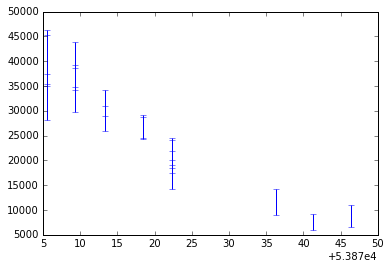

In [99]:
plt.errorbar(lc2['mjd'], f_lc2, yerr=f_e2, linestyle='None')

<Container object of 3 artists>

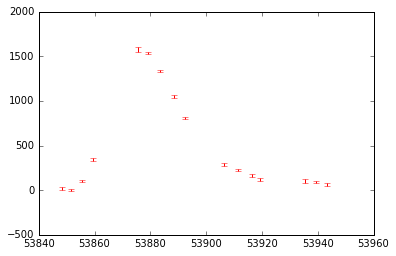

In [103]:

plt.errorbar(lc['mjd'], lc['flux'], yerr=lc['flux_error'], linestyle='None', color='red')

In [153]:
import math

In [104]:
mjds = []
m_fluxes = []
m_error = []
i = 0
while i < len(lc2['mjd']):
    mjd = lc2['mjd'][i]
    j = i+1
    mjds.append(int(mjd))
    m_fluxes.append(lc2['flux'][i])
    m_error.append(lc2['flux_error'][i])
    total = 1.
    
    while j<len(lc2['mjd']) and int(lc2['mjd'][j]) == int(mjd):
        
        m_fluxes[-1]+= lc2['flux'][j]
        m_error[-1] += lc2['flux_error'][j]
        #mjds[-1] += int(lc2['mjd'][j])
        total+=1
        j+=1
    m_fluxes[-1] = np.divide(m_fluxes[-1], total)
    m_error[-1] = np.divide(m_error[-1], total)
    i = j
        

In [105]:
factor = max(lc['flux']) / max(m_fluxes)

f_lc2 = np.multiply(m_fluxes, factor)
f_e2 = np.multiply(m_error, factor)


<Container object of 3 artists>

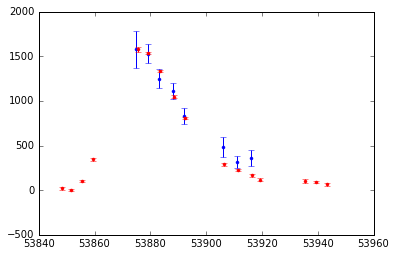

In [106]:
plt.errorbar(mjds, f_lc2, yerr=f_e2, fmt='.')
plt.errorbar(lc['mjd'], lc['flux'], yerr=lc['flux_error'], fmt='.', color='red')